**DeapSECURE module 4: Deap Learning**

# Session 3: Model Tuning

Welcome to the DeapSECURE online training program!
This is a Jupyter notebook for the hands-on learning activities of the
["Deep Learning" (DL) module](https://deapsecure.gitlab.io/deapsecure-lesson04-nn/),
Episode 6: ["Tuning Neural Network Models for Better Accuracy"](https://deapsecure.gitlab.io/deapsecure-lesson04-nn/30-model-tuning/index.html).
Please visit the [DeapSECURE](https://deapsecure.gitlab.io/) website to learn more about our training program.

## Overview

In this session, we will use this notebook to **tune** neural network models to improve the accuracy of the classification task on the Sherlock's "Applications" dataset.
We will be using the same dataset, which contains 18 applications.

> **Your challenge** in this notebook is to train more neural network models using the "18-apps" dataset to improve the classification accuracy of the model. Can we reach 99%? How about 99.9%? Or 99.99%?

> **DISCUSSION**: In cybersecurity, why do we care about 99.99% or even 99.999% accuracy?
> Think, for example, the case of spam detection.
> What will happen if we falsely mark many legitimate emails as spam?
> Or let many spam mails enter into your inbox?

**QUICK LINKS**
* [Setup](#sec-setup)
* [Loading Sherlock Applications Data](#sec-load_data)
* [Neural Network Models](#sec-NN)
* [Model Tuning Methods](#sec-Model_Tuning_Methods)

<a id="sec-setup"></a>
## 1. Setup Instructions

If you are opening this notebook from the Wahab OnDemand interface, you're all set.

If you see this notebook elsewhere, and want to perform the exercises on Wahab cluster, please follow the steps outlined in our setup procedure.

1. Make sure you have activated your HPC service.
2. Point your web browser to https://ondemand.wahab.hpc.odu.edu/ and sign in with your MIDAS ID and password.
3. Create a new Jupyter session with the following parameters: Python version **3.7**, Python suite `tensorflow 2.6 + pytorch 1.10`, Number of Cores **4**, Number of GPU **0**, Partition `main`, and Number of Hours at least **4**. (See <a href="https://wiki.hpc.odu.edu/en/ood-jupyter" target="_blank">ODU HPC wiki</a> for more detailed help.)
4. From the JupyterLab launcher, start a new Terminal session. Then issue the following commands to get the necessary files:

       mkdir -p ~/CItraining/module-nn
       cp -pr /shared/DeapSECURE/module-nn/. ~/CItraining/module-nn

Using the file manager on the left sidebar, now change the working directory to `~/CItraining/module-nn`.
The file name of this notebook is `NN-session-3.ipynb`.

For the more advanced solution that includes a more complex method of saving metadata, make sure to uncomment any block marked #AdvMetadataVersion.
This alternative changes the post-processing csv to contain more metadata and all of the epoch `loss`, `val_loss`, `accuracy`, and `val_accuracy`.

### 1.1 Reminder

* Throughout this notebook, `#TODO` is used as a placeholder where you need to fill in with something appropriate. 

* To run a code in a cell, press `Shift+Enter`.

* <a href="https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf" target="_blank">Pandas cheatsheet</a>

* <a href="https://deapsecure.gitlab.io/deapsecure-lesson02-bd/10-pandas-intro/index.html#summary-indexing-syntax" target="_blank">Summary table of the commonly used indexing (subscripting) syntax</a> from our own lesson.

* <a href="https://keras.io/api/" target="_blank">Keras API document</a>

We recommend you open these on separate tabs or print them;
they are handy help for writing your own codes.

### 1.2 Loading Python Libraries

First step, we need to import the required libraries into this Jupyter Notebook:
`pandas`, `numpy`,`matplotlib.pyplot`, and `tensorflow`.

In [1]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# CUSTOMIZATIONS (optional)
np.set_printoptions(linewidth=1000)

%matplotlib inline

In [2]:
# tools for deep learning:
import tensorflow as tf
import tensorflow.keras as keras

# Import key Keras objects
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [3]:
# Import ML toolbox functions
from sherlock_ML_toolbox import load_prep_data_18apps, split_data_18apps, \
NN_Model_1H, plot_loss, plot_acc, combine_loss_acc_plots, fn_out_history_1H, \
model_layer_code_XH, fn_dir_tuning_XH, fn_out_history_XH

<a id="sec-load_data"></a>
## 2. Loading Sherlock Applications Data

Utilize the toolbox sherlock_ML_toolbox.py to load in the data, 
preprocess the data (data cleaning, label/feature separation,
feature normalization/scaling, etc.) until it is ready for ML except
for train-validation splitting.

In [4]:
# Load in the pre-processed SherLock data.
datafile = "sherlock/sherlock_18apps.csv"
df_orig, df, labels, df_labels_onehot, df_features \
    = load_prep_data_18apps(datafile, print_summary=True)

# Split the data into train and validation datasets with their respective features and labels.
train_features, val_features, train_labels, val_labels, train_L_onehot, val_L_onehot \
    = split_data_18apps(df_features, labels, df_labels_onehot)

Loading input data from: sherlock/sherlock_18apps.csv
* shape: (273129, 19)

* info::

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273129 entries, 0 to 999994
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ApplicationName    273129 non-null  object 
 1   CPU_USAGE          273077 non-null  float64
 2   UidRxBytes         273129 non-null  int64  
 3   UidRxPackets       273129 non-null  int64  
 4   UidTxBytes         273129 non-null  int64  
 5   UidTxPackets       273129 non-null  int64  
 6   cutime             273077 non-null  float64
 7   guest_time         273077 non-null  float64
 8   importance         273129 non-null  int64  
 9   lru                273129 non-null  int64  
 10  num_threads        273077 non-null  float64
 11  otherPrivateDirty  273129 non-null  int64  
 12  priority           273077 non-null  float64
 13  rss                273077 non-null  float64
 14  state        

In [5]:
print("First 10 rows/entries from the preprocessed data:")
df.head(10)

First 10 rows/entries from the preprocessed data:


,ApplicationName,CPU_USAGE,UidRxBytes,UidRxPackets,UidTxBytes,UidTxPackets,cutime,importance,lru,num_threads,otherPrivateDirty,priority,rss,state,stime,utime,vsize
0,Gmail,0.13,0,0,0,0,0.0,400,15,32.0,8300,20.0,10957.0,S,180.0,311.0,2.064265e+09
6,Hangouts,1.65,0,0,0,0,0.0,400,15,17.0,27284,20.0,20043.0,S,67.0,210.0,2.047980e+09
11,Messenger,0.21,0,0,0,0,0.0,300,0,72.0,11324,20.0,13891.0,S,395.0,542.0,2.106794e+09
18,Geo News,0.03,0,0,0,0,0.0,300,0,14.0,860,20.0,5694.0,S,43.0,39.0,1.893417e+09
19,Facebook,0.20,0,0,0,0,0.0,300,0,77.0,5776,20.0,8511.0,S,401.0,464.0,2.204619e+09
28,Google App,0.51,266,3,208,4,0.0,300,0,94.0,25912,20.0,17688.0,S,992.0,1760.0,2.273260e+09
29,Calendar,0.03,0,0,0,0,0.0,400,15,25.0,5304,20.0,7944.0,S,24.0,39.0,1.929048e+09
32,Photos,0.02,0,0,0,0,0.0,300,0,11.0,88,20.0,3959.0,S,16.0,54.0,1.923707e+09
35,ES File Explorer,0.08,0,0,0,0,0.0,400,13,20.0,3284,20.0,6674.0,S,121.0,168.0,1.960612e+09
39,Google App,0.00,0,0,0,0,0.0,200,0,10.0,556,20.0,2961.0,S,153.0,65.0,1.920733e+09


In [6]:
print("Last 10 rows/entries from the preprocessed data:")
df.tail(10)

Last 10 rows/entries from the preprocessed data:


,ApplicationName,CPU_USAGE,UidRxBytes,UidRxPackets,UidTxBytes,UidTxPackets,cutime,importance,lru,num_threads,otherPrivateDirty,priority,rss,state,stime,utime,vsize
999961,Facebook,0.13,0,0,0,0,0.0,300,0,11.0,1444,20.0,4543.0,S,21.0,23.0,2.100892e+09
999962,Chrome,0.04,0,0,0,0,0.0,400,15,10.0,196,20.0,3702.0,S,9.0,4.0,1.897894e+09
999972,Maps,0.12,0,0,0,0,0.0,400,15,25.0,340,20.0,4128.0,S,55.0,106.0,1.994244e+09
999976,Gmail,0.31,0,0,0,0,0.0,400,11,30.0,8964,20.0,11606.0,S,157.0,257.0,2.032255e+09
999977,Facebook,0.20,0,0,0,0,0.0,400,15,10.0,396,20.0,4961.0,S,13.0,24.0,2.095329e+09
999984,Skype,1.79,0,0,0,0,0.0,400,15,31.0,12596,20.0,18691.0,S,78.0,84.0,1.999364e+09
999985,Hangouts,2.00,0,0,0,0,0.0,400,9,48.0,12760,20.0,7572.0,S,1090.0,2827.0,2.154717e+09
999989,Facebook,0.19,0,0,0,0,0.0,300,0,134.0,66296,20.0,28900.0,S,4038.0,4529.0,2.372964e+09
999991,Messenger,0.09,0,0,0,0,0.0,300,0,81.0,6556,20.0,9671.0,S,2293.0,1867.0,2.127880e+09
999994,Geo News,0.02,0,0,0,0,0.0,300,0,23.0,756,20.0,3661.0,S,512.0,413.0,1.907130e+09


<a id="sec-NN"></a>
## 3. Neural Network Model with One Hidden Layer -- the Baseline

Let us now start by building a simple neural network model with just one hidden layer.
This will serve as a *baseline*, which we will attempt to improve through the tuning process below.

### Aside: Metadata

(Experiment) metadata: provides context about each run/experiment.
Saving metadata provides the user with a quick way to recall 
important information about a particular run/experiment.

In these experiments, we will save the following metadata:
 - Expt_ID: shorthand of the naming convention along with the type of experiment
 - Job_ID: this will be unique for each experiment
 - hidden_neurons: as a list, where each element is the number of hidden neurons in that layer
 - learning_rate
 - batch_size
 
This metadata can either be saved during each experiment (this helps ensure that no mistakes are made);
or, it can be saved after if the user is very careful to remember
what to fill in for each run.

Since these experiments very methodically scan the hyperparameter
space, we will collect the metadata at the end of each experiment type.

### 3.1 The Baseline Model

The baseline neural network model has one hidden layer with `18` hidden neurons and a learning rate of `0.0003`. It is trained with a batch size of 32.

Let us train this model with an initial *learning rate* of 0.0003.

In [8]:
# Create the outer hidden_neurons directory
dir0_HN = "scan-hidden-neurons/"
if not os.path.exists(dir0_HN):
        os.makedirs(dir0_HN)

In [10]:
## Helper function

def saveOutputs_HN(numNeurons, currHistory, currModel):
    """
    Save the outputs of the hidden neurons model tuning experiments.
    It will create a directory within the hidden neurons directory with the 
    MODEL_DIR name.
    Save within this folder the following: 
    1. A loss_acc_plot.png that is the training and validation loss vs. epochs
      and the training and validation accuracy vs. epochs graphs.
    2. model_history.csv that contains the training and validation loss and
      accuracy per epoch data.
    3. model_weights.h5 that contains the saved model.
    
    Args:
      numNeurons: the number of hidden neurons used in this experiment.
      currHistory: the current history object used to create (and then save) the CSV and plot files.
      currModel: the current model to save.
    
    """
    # Create model output directory
    model_name = "model_1H" + str(numNeurons) + "N_lr" + str(0.0003) + "_bs" + str(32) + "_e" + str(10)
    MODEL_DIR = dir0_HN+model_name
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)

    ## Save the Output

    # Utilize os.path.join to add the output files to the MODEL_DIR defined above.
    history_file = os.path.join(MODEL_DIR, 'model_history.csv')
    plot_file = os.path.join(MODEL_DIR, 'loss_acc_plot.png')
    model_file = os.path.join(MODEL_DIR, 'model_weights.h5')

    # save the history into a CSV file
    history_df = pd.DataFrame(currHistory.history)
    history_df.to_csv(history_file, index=False)

    # save the plots using the toolbox function and then add a title
    combine_loss_acc_plots(currHistory, plot_loss, plot_acc, show=False)
    plt.suptitle(model_name, fontsize=15)
    plt.savefig(plot_file)

    # save the model
    currModel.save(model_file)

In [11]:
#RUNIT
# Reproducibility hacks!

np.random.seed(38477518)
tf.random.set_seed(967288341)

In [12]:
model_1H = NN_Model_1H(18,0.0003)
model_1H_history = model_1H.fit(train_features,
                                train_L_onehot,
                                epochs=10, batch_size=32,
                                validation_data=(val_features, val_L_onehot),
                                verbose=2)

2025-08-09 11:00:07.623126: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-08-09 11:00:07.623183: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (d4-w6420b-10): /proc/driver/nvidia/version does not exist
2025-08-09 11:00:07.633289: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Created model: NN_Model_1H
 - hidden_layers  = 1
 - hidden_neurons = 18
 - optimizer      = Adam
 - learning_rate  = 0.0003



2025-08-09 11:00:08.110350: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
6827/6827 - 7s - loss: 1.1037 - accuracy: 0.6752 - val_loss: 0.5488 - val_accuracy: 0.8702
Epoch 2/10
6827/6827 - 6s - loss: 0.4071 - accuracy: 0.9047 - val_loss: 0.3205 - val_accuracy: 0.9245
Epoch 3/10
6827/6827 - 6s - loss: 0.2743 - accuracy: 0.9319 - val_loss: 0.2425 - val_accuracy: 0.9385
Epoch 4/10
6827/6827 - 6s - loss: 0.2177 - accuracy: 0.9468 - val_loss: 0.1990 - val_accuracy: 0.9509
Epoch 5/10
6827/6827 - 6s - loss: 0.1818 - accuracy: 0.9592 - val_loss: 0.1692 - val_accuracy: 0.9628
Epoch 6/10
6827/6827 - 6s - loss: 0.1561 - accuracy: 0.9664 - val_loss: 0.1470 - val_accuracy: 0.9671
Epoch 7/10
6827/6827 - 6s - loss: 0.1363 - accuracy: 0.9703 - val_loss: 0.1296 - val_accuracy: 0.9708
Epoch 8/10
6827/6827 - 6s - loss: 0.1209 - accuracy: 0.9740 - val_loss: 0.1171 - val_accuracy: 0.9739
Epoch 9/10
6827/6827 - 6s - loss: 0.1089 - accuracy: 0.9769 - val_loss: 0.1058 - val_accuracy: 0.9770
Epoch 10/10
6827/6827 - 6s - loss: 0.0995 - accuracy: 0.9786 - val_loss: 0.0970 - 

In [13]:
#AdvMetadataVersion
# metadata for the model - (Expt_ID, Job_ID, hidden_neurons, learning_rate, batch_size, epoch)
model_1H_data = ('1H18N-neuron', 0, '[18]', 0.0003, 32, 10)

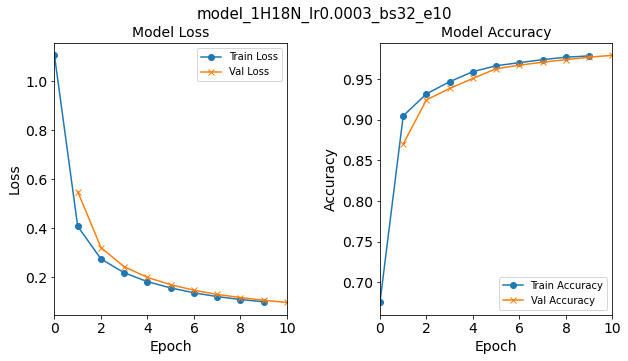

In [14]:
# Save the outputs
saveOutputs_HN(18, model_1H_history, model_1H)

<a id="sec-Model_Tuning_Methods"></a>
## 4 Model Tuning Methods

Now that we have built and trained the baseline neural network model, we will run a variety of experiments using different combinations of *hyperparameters*, in order to find the best performing model.
A secondary goal is to investigate how increasing or decreasing a hyperparameter affects the accuracy of the model.
Below is a list of hyperparameters that could be interesting to explore; feel free to experiment with your own ideas as well.

We will use the `NN_Model_1H` with 18 neurons in the hidden layer as a baseline.
Starting from this model, let us: 

- val with different numbers of neurons in the hidden layer: **12**, **8**, **4**, **2**, **1**
    - It is also worthwhile to val a higher number of neurons: **40**, **80**, or more
- val with different learning rates: **0.0003**, **0.001**, **0.01**, **0.1**
- val with different batch sizes: **16**, **32**, **64**, **128**, **512**, **1024**
- val with different numbers of hidden layers: **2**, **3**, and so on

> **NOTE:**
> The easiest way to do this exploration is to simply copy the code cell where we constructed and trained the baseline model and paste it to a new cell below, since most of the parameters (`hidden_neurons`, `learning_rate`, `batch_size`, etc.) can be changed when calling the `NN_Model_1H` function or when fitting the model.
> However, to change the number of hidden layers (which we will do much later), the original `NN_model_1H` function must be duplicated and modified.

#### Post-Processing

To take advantage of Jupyter Notebook's ability to immediately inspect graphical 
elements, part of the post-processing will be done after each model's run.
Inspect the resulting loss and accuracy graphs and answer the following.

**QUESTIONS**: Based on the plots shown above (for the baseline model), inspect whether the training runs went as expected.

1) Visually inspect for any anomalies. Note the runs that produce "abonrmal training trends", i.e., where the "loss vs. epochs" and/or "accuracy vs. epochs" curves exhibit a different behavior from what shown for the baseline model.

2) Visually (or numerically) check for convergence (e.g. check the loss or accuracy for the last 4-5 epochs; what their slopes look like in this region; any fluctuations?)

3) Observe the differences in the *final* accuracies as a result of different `hidden_neurons` values. (We will do this more carefully in the next phase)


### 4.1 Tuning Experiments #1: Varying Number of Neurons in Hidden Layers

In this round of experiments, we create several variants of `NN_Model_1H` models with varying the `hidden_neurons` hyperparameter, i.e. the number of neurons in the hidden layer.
The accuracy and loss of each model will be assessed as a function of `hidden_neurons`.
All the other hyperparameters (e.g. learning rate, epochs, batch_size, number of hidden layers) will be kept constant; they will be varied later.
Not every number of hidden neurons is tested, so feel free to create new code cells with a different number of neurons as your curiousity leads you.

##### Model "1H12N": 12 neurons in the hidden layer

In [15]:
#RUNIT
# Reproducibility hacks!

np.random.seed(968172)
tf.random.set_seed(83018241)

In [16]:
"""Construct & train a NN_Model_1H with 12 neurons in the hidden layer""";

#RUNIT
# the model with 12 neurons in the hidden layer 
model_1H12N = NN_Model_1H(12,0.0003)
model_1H12N_history = model_1H12N.fit(train_features,
                                      train_L_onehot,
                                      epochs=10, batch_size=32,
                                      validation_data=(val_features, val_L_onehot),
                                      verbose=2)

Created model: NN_Model_1H
 - hidden_layers  = 1
 - hidden_neurons = 12
 - optimizer      = Adam
 - learning_rate  = 0.0003

Epoch 1/10
6827/6827 - 6s - loss: 1.1864 - accuracy: 0.6581 - val_loss: 0.6118 - val_accuracy: 0.8622
Epoch 2/10
6827/6827 - 6s - loss: 0.4592 - accuracy: 0.8992 - val_loss: 0.3700 - val_accuracy: 0.9217
Epoch 3/10
6827/6827 - 6s - loss: 0.3286 - accuracy: 0.9277 - val_loss: 0.2997 - val_accuracy: 0.9331
Epoch 4/10
6827/6827 - 6s - loss: 0.2803 - accuracy: 0.9349 - val_loss: 0.2659 - val_accuracy: 0.9381
Epoch 5/10
6827/6827 - 6s - loss: 0.2531 - accuracy: 0.9381 - val_loss: 0.2437 - val_accuracy: 0.9407
Epoch 6/10
6827/6827 - 6s - loss: 0.2328 - accuracy: 0.9413 - val_loss: 0.2253 - val_accuracy: 0.9448
Epoch 7/10
6827/6827 - 6s - loss: 0.2161 - accuracy: 0.9455 - val_loss: 0.2105 - val_accuracy: 0.9507
Epoch 8/10
6827/6827 - 6s - loss: 0.2026 - accuracy: 0.9496 - val_loss: 0.1983 - val_accuracy: 0.9549
Epoch 9/10
6827/6827 - 6s - loss: 0.1908 - accuracy: 0.9540

In [17]:
#AdvMetadataVersion

# metadata for the model - (Expt_ID, Job_ID, hidden_neurons, learning_rate, batch_size, epoch)
model_1H12N_data = ('1H12N-neuron', 1, '[12]', 0.0003, 32, 10) 

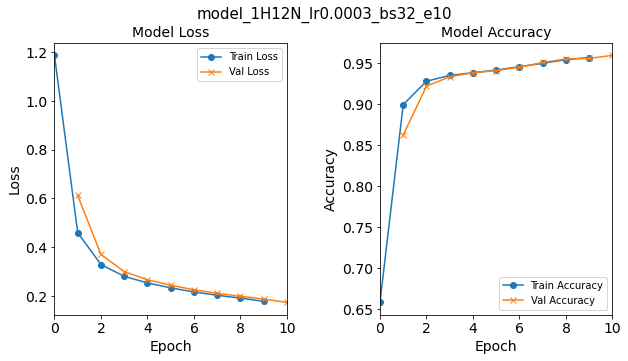

In [18]:
# save the outputs
saveOutputs_HN(12, model_1H12N_history, model_1H12N)

##### Model "1H8N": 8 neurons in the hidden layer

In [19]:
#RUNIT
# Reproducibility hacks!

np.random.seed(491717)
tf.random.set_seed(3901141)

In [20]:
model_1H8N = NN_Model_1H(8,0.0003)
model_1H8N_history = model_1H8N.fit(train_features,
                                    train_L_onehot,
                                    epochs=10, batch_size=32,
                                    validation_data=(val_features, val_L_onehot),
                                    verbose=2)

Created model: NN_Model_1H
 - hidden_layers  = 1
 - hidden_neurons = 8
 - optimizer      = Adam
 - learning_rate  = 0.0003

Epoch 1/10
6827/6827 - 6s - loss: 1.4420 - accuracy: 0.5361 - val_loss: 0.9016 - val_accuracy: 0.7646
Epoch 2/10
6827/6827 - 6s - loss: 0.6984 - accuracy: 0.8269 - val_loss: 0.5523 - val_accuracy: 0.8674
Epoch 3/10
6827/6827 - 6s - loss: 0.4725 - accuracy: 0.8843 - val_loss: 0.4205 - val_accuracy: 0.8979
Epoch 4/10
6827/6827 - 7s - loss: 0.3848 - accuracy: 0.9112 - val_loss: 0.3640 - val_accuracy: 0.9167
Epoch 5/10
6827/6827 - 6s - loss: 0.3445 - accuracy: 0.9195 - val_loss: 0.3347 - val_accuracy: 0.9224
Epoch 6/10
6827/6827 - 6s - loss: 0.3217 - accuracy: 0.9235 - val_loss: 0.3158 - val_accuracy: 0.9258
Epoch 7/10
6827/6827 - 6s - loss: 0.3057 - accuracy: 0.9269 - val_loss: 0.3015 - val_accuracy: 0.9272
Epoch 8/10
6827/6827 - 6s - loss: 0.2935 - accuracy: 0.9302 - val_loss: 0.2909 - val_accuracy: 0.9323
Epoch 9/10
6827/6827 - 6s - loss: 0.2833 - accuracy: 0.9319 

In [21]:
#AdvMetadataVersion
# metadata for the model - (Expt_ID, Job_ID, hidden_neurons, learning_rate, batch_size, epoch)
model_1H8N_data = ('1H8N-neuron', 2, '[8]', 0.0003, 32, 10) 

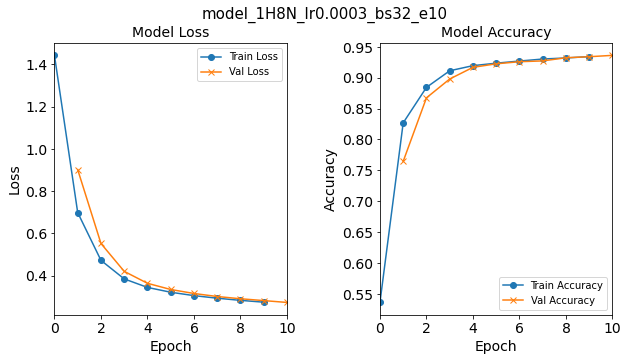

In [22]:
# save the outputs
saveOutputs_HN(8, model_1H8N_history, model_1H8N)

> ### Tips & Tricks for Experimental Runs
>
> Do you see the systematic names of the model and history variables, etc?
> The variable called `model_1H12N` means "a model with one hidden layer (`1H`) that has 12 neurons (`12N`)".
> The use of systematic names, albeit complicated, will be very helpful in keeping track of different experiments.
> For example, down below, we will have models with two hidden layers; such a model can be denoted by a variable name such as `model_2H18N12N`, etc.
>
> **DISCUSSION QUESTION:**
> Why don't we just name the variables `model1`, `model2`, `model3`, ...?
> What are the advantages and disadvantages of naming them with this schema?
>
> **Keeping track of experimental results**:
> At this stage, it may be helpful to keep track the final training accuracy (at the last epoch) for each model with a distinct `hidden_neurons` value.
> You can use pen-and-paper, or build a spreadsheet with the following
> values:
>
> | `hidden_neurons` | `val_accuracy` |
> |------------------|----------------|
> |        1         |      ....      |
> |       ...        |      ....      |
> |       18         | 0.9792 (example) |
> |       ...        |      ....      |
> |       80         |      ....      |

**EXERCISES**: create additional code cells to run models with 4, 2, 1 neurons in the hidden layer

##### Model "1H4N": 4 neurons in the hidden layer

In [23]:
#RUNIT
# Reproducibility hacks!

np.random.seed(51568717)
tf.random.set_seed(314782)

In [24]:
model_1H4N = NN_Model_1H(4,0.0003)
model_1H4N_history = model_1H4N.fit(train_features,
                                    train_L_onehot,
                                    epochs=10, batch_size=32,
                                    validation_data=(val_features, val_L_onehot),
                                    verbose=2)

Created model: NN_Model_1H
 - hidden_layers  = 1
 - hidden_neurons = 4
 - optimizer      = Adam
 - learning_rate  = 0.0003

Epoch 1/10
6827/6827 - 6s - loss: 1.6787 - accuracy: 0.4199 - val_loss: 1.2247 - val_accuracy: 0.5768
Epoch 2/10
6827/6827 - 6s - loss: 1.0693 - accuracy: 0.6315 - val_loss: 0.9432 - val_accuracy: 0.6934
Epoch 3/10
6827/6827 - 6s - loss: 0.8440 - accuracy: 0.7524 - val_loss: 0.7699 - val_accuracy: 0.7884
Epoch 4/10
6827/6827 - 6s - loss: 0.7248 - accuracy: 0.7993 - val_loss: 0.6817 - val_accuracy: 0.8122
Epoch 5/10
6827/6827 - 6s - loss: 0.6571 - accuracy: 0.8325 - val_loss: 0.6291 - val_accuracy: 0.8449
Epoch 6/10
6827/6827 - 6s - loss: 0.6146 - accuracy: 0.8495 - val_loss: 0.5927 - val_accuracy: 0.8491
Epoch 7/10
6827/6827 - 6s - loss: 0.5846 - accuracy: 0.8541 - val_loss: 0.5679 - val_accuracy: 0.8601
Epoch 8/10
6827/6827 - 6s - loss: 0.5640 - accuracy: 0.8572 - val_loss: 0.5498 - val_accuracy: 0.8783
Epoch 9/10
6827/6827 - 6s - loss: 0.5483 - accuracy: 0.8659 

In [25]:
#AdvMetadataVersion
# metadata for the model - (Expt_ID, Job_ID, hidden_neurons, learning_rate, batch_size, epoch)
model_1H4N_data = ('1H4N-neuron', 3, '[4]', 0.0003, 32, 10) 

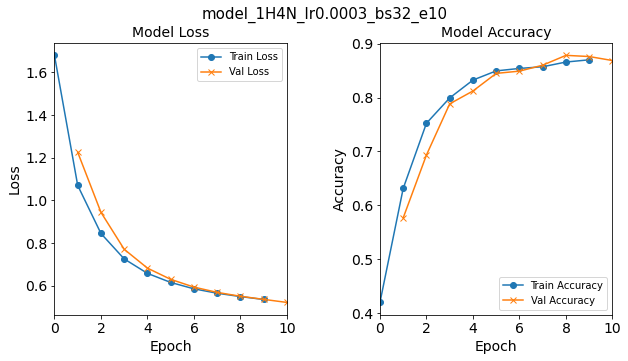

In [26]:
# save the outputs
saveOutputs_HN(4, model_1H4N_history, model_1H4N)

##### Model "1H2N": 2 neurons in the hidden layer

In [27]:
#RUNIT
# Reproducibility hacks!

np.random.seed(66962476)
tf.random.set_seed(41840828)

In [28]:
#RUNIT
model_1H2N = NN_Model_1H(2,0.0003)
model_1H2N_history = model_1H2N.fit(train_features,
                                    train_L_onehot,
                                    epochs=10, batch_size=32,
                                    validation_data=(val_features, val_L_onehot),
                                    verbose=2)

Created model: NN_Model_1H
 - hidden_layers  = 1
 - hidden_neurons = 2
 - optimizer      = Adam
 - learning_rate  = 0.0003

Epoch 1/10
6827/6827 - 6s - loss: 2.1385 - accuracy: 0.2973 - val_loss: 1.8072 - val_accuracy: 0.3491
Epoch 2/10
6827/6827 - 6s - loss: 1.6945 - accuracy: 0.3901 - val_loss: 1.6147 - val_accuracy: 0.4122
Epoch 3/10
6827/6827 - 6s - loss: 1.5603 - accuracy: 0.4286 - val_loss: 1.5186 - val_accuracy: 0.4345
Epoch 4/10
6827/6827 - 6s - loss: 1.4834 - accuracy: 0.4416 - val_loss: 1.4552 - val_accuracy: 0.4462
Epoch 5/10
6827/6827 - 6s - loss: 1.4283 - accuracy: 0.4535 - val_loss: 1.4069 - val_accuracy: 0.4610
Epoch 6/10
6827/6827 - 6s - loss: 1.3843 - accuracy: 0.4677 - val_loss: 1.3668 - val_accuracy: 0.4711
Epoch 7/10
6827/6827 - 6s - loss: 1.3467 - accuracy: 0.4811 - val_loss: 1.3322 - val_accuracy: 0.4803
Epoch 8/10
6827/6827 - 6s - loss: 1.3153 - accuracy: 0.4931 - val_loss: 1.3039 - val_accuracy: 0.4937
Epoch 9/10
6827/6827 - 6s - loss: 1.2892 - accuracy: 0.5089 

In [29]:
#AdvMetadataVersion
# metadata for the model - (Expt_ID, Job_ID, hidden_neurons, learning_rate, batch_size, epoch)
model_1H2N_data = ('1H2N-neuron', 4, '[2]', 0.0003, 32, 10) 

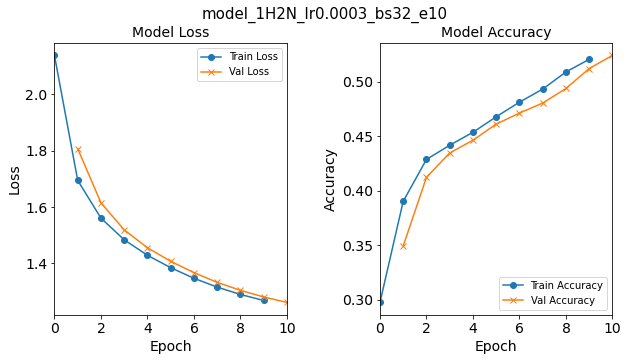

In [30]:
# save the outputs
saveOutputs_HN(2, model_1H2N_history, model_1H2N)

##### Model "1H1N": 1 neurons in the hidden layer

In [31]:
#RUNIT
# Reproducibility hacks!

np.random.seed(50383027)
tf.random.set_seed(72907479)

In [32]:
model_1H1N = NN_Model_1H(1,0.0003)
model_1H1N_history = model_1H1N.fit(train_features,
                                    train_L_onehot,
                                    epochs=10, batch_size=32,
                                    validation_data=(val_features, val_L_onehot),
                                    verbose=2)

Created model: NN_Model_1H
 - hidden_layers  = 1
 - hidden_neurons = 1
 - optimizer      = Adam
 - learning_rate  = 0.0003

Epoch 1/10
6827/6827 - 6s - loss: 2.3351 - accuracy: 0.2485 - val_loss: 2.1355 - val_accuracy: 0.2752
Epoch 2/10
6827/6827 - 6s - loss: 2.0610 - accuracy: 0.2724 - val_loss: 2.0034 - val_accuracy: 0.2723
Epoch 3/10
6827/6827 - 7s - loss: 1.9741 - accuracy: 0.2745 - val_loss: 1.9494 - val_accuracy: 0.2825
Epoch 4/10
6827/6827 - 6s - loss: 1.9346 - accuracy: 0.2829 - val_loss: 1.9205 - val_accuracy: 0.2857
Epoch 5/10
6827/6827 - 6s - loss: 1.9118 - accuracy: 0.2885 - val_loss: 1.9036 - val_accuracy: 0.2934
Epoch 6/10
6827/6827 - 6s - loss: 1.8976 - accuracy: 0.2937 - val_loss: 1.8930 - val_accuracy: 0.3008
Epoch 7/10
6827/6827 - 6s - loss: 1.8883 - accuracy: 0.3000 - val_loss: 1.8856 - val_accuracy: 0.3009
Epoch 8/10
6827/6827 - 6s - loss: 1.8819 - accuracy: 0.3048 - val_loss: 1.8808 - val_accuracy: 0.3149
Epoch 9/10
6827/6827 - 6s - loss: 1.8774 - accuracy: 0.3097 

In [33]:
#AdvMetadataVersion
# metadata for the model - (Expt_ID, Job_ID, hidden_neurons, learning_rate, batch_size, epoch)
model_1H1N_data = ('1H1N-neuron', 5, '[1]', 0.0003, 32, 10) 

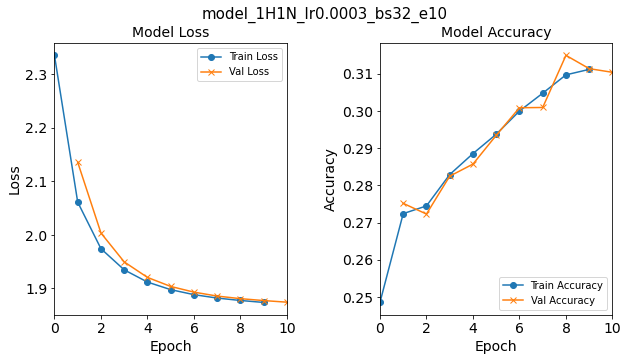

In [34]:
# save the outputs
saveOutputs_HN(1, model_1H1N_history, model_1H1N)

**EXERCISES**: create more code cells to run models with 40 and 80 neurons in the hidden layer. *You are welcome to explore even higher numbers of hidden neurons. Observe carefully what happening!*

##### Model "1H40N": 40 neurons in the hidden layer

In [35]:
#RUNIT
# Reproducibility hacks!

np.random.seed(34294506)
tf.random.set_seed(1139397)

In [36]:
model_1H40N = NN_Model_1H(40,0.0003)
model_1H40N_history = model_1H40N.fit(train_features,
                                      train_L_onehot,
                                      epochs=10, batch_size=32,
                                      validation_data=(val_features, val_L_onehot),
                                      verbose=2)

Created model: NN_Model_1H
 - hidden_layers  = 1
 - hidden_neurons = 40
 - optimizer      = Adam
 - learning_rate  = 0.0003

Epoch 1/10
6827/6827 - 7s - loss: 0.8427 - accuracy: 0.7706 - val_loss: 0.3632 - val_accuracy: 0.9180
Epoch 2/10
6827/6827 - 6s - loss: 0.2798 - accuracy: 0.9339 - val_loss: 0.2265 - val_accuracy: 0.9456
Epoch 3/10
6827/6827 - 6s - loss: 0.1958 - accuracy: 0.9533 - val_loss: 0.1706 - val_accuracy: 0.9637
Epoch 4/10
6827/6827 - 6s - loss: 0.1519 - accuracy: 0.9658 - val_loss: 0.1364 - val_accuracy: 0.9689
Epoch 5/10
6827/6827 - 6s - loss: 0.1226 - accuracy: 0.9718 - val_loss: 0.1113 - val_accuracy: 0.9733
Epoch 6/10
6827/6827 - 6s - loss: 0.1014 - accuracy: 0.9770 - val_loss: 0.0931 - val_accuracy: 0.9796
Epoch 7/10
6827/6827 - 6s - loss: 0.0864 - accuracy: 0.9805 - val_loss: 0.0810 - val_accuracy: 0.9815
Epoch 8/10
6827/6827 - 6s - loss: 0.0755 - accuracy: 0.9825 - val_loss: 0.0704 - val_accuracy: 0.9822
Epoch 9/10
6827/6827 - 6s - loss: 0.0667 - accuracy: 0.9848

In [37]:
# metadata for the model - (Expt_ID, Job_ID, hidden_neurons, learning_rate, batch_size, epoch)
model_1H40N_data = ('1H40N-neuron', 6, '[40]', 0.0003, 32, 10) 

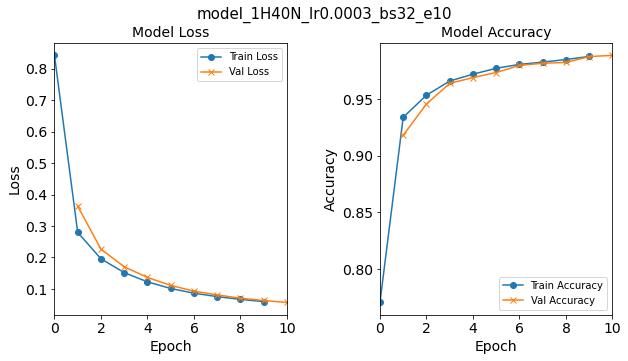

In [38]:
# save the outputs
saveOutputs_HN(40, model_1H40N_history, model_1H40N)

##### Model "1H80N": 80 neurons in the hidden layer

In [39]:
#RUNIT
# Reproducibility hacks!

np.random.seed(4035104)
tf.random.set_seed(84845624)

In [40]:
model_1H80N = NN_Model_1H(80,0.0003)
model_1H80N_history = model_1H80N.fit(train_features,
                                      train_L_onehot,
                                      epochs=10, batch_size=32,
                                      validation_data=(val_features, val_L_onehot),
                                      verbose=2)

Created model: NN_Model_1H
 - hidden_layers  = 1
 - hidden_neurons = 80
 - optimizer      = Adam
 - learning_rate  = 0.0003

Epoch 1/10
6827/6827 - 7s - loss: 0.6815 - accuracy: 0.8244 - val_loss: 0.2710 - val_accuracy: 0.9327
Epoch 2/10
6827/6827 - 6s - loss: 0.2048 - accuracy: 0.9492 - val_loss: 0.1580 - val_accuracy: 0.9629
Epoch 3/10
6827/6827 - 6s - loss: 0.1291 - accuracy: 0.9708 - val_loss: 0.1058 - val_accuracy: 0.9786
Epoch 4/10
6827/6827 - 6s - loss: 0.0900 - accuracy: 0.9808 - val_loss: 0.0764 - val_accuracy: 0.9829
Epoch 5/10
6827/6827 - 6s - loss: 0.0669 - accuracy: 0.9865 - val_loss: 0.0587 - val_accuracy: 0.9888
Epoch 6/10
6827/6827 - 6s - loss: 0.0525 - accuracy: 0.9902 - val_loss: 0.0463 - val_accuracy: 0.9915
Epoch 7/10
6827/6827 - 7s - loss: 0.0424 - accuracy: 0.9919 - val_loss: 0.0377 - val_accuracy: 0.9925
Epoch 8/10
6827/6827 - 6s - loss: 0.0351 - accuracy: 0.9931 - val_loss: 0.0326 - val_accuracy: 0.9933
Epoch 9/10
6827/6827 - 6s - loss: 0.0299 - accuracy: 0.9939

In [41]:
#AdvMetadataVersion
# metadata for the model - (Expt_ID, Job_ID, hidden_neurons, learning_rate, batch_size, epoch)
model_1H80N_data = ('1H80N-neuron', 7, '[80]', 0.0003, 32, 10) 

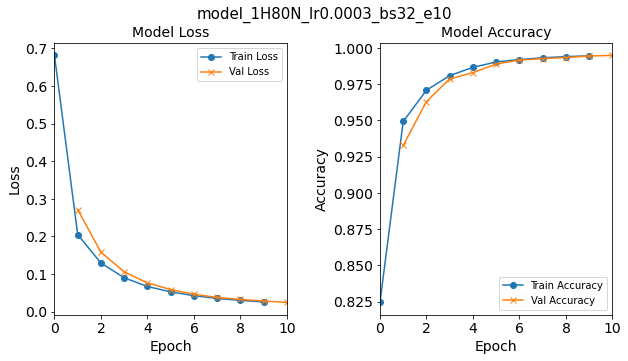

In [42]:
# save the outputs
saveOutputs_HN(80, model_1H80N_history, model_1H80N)

#### Post Processing for Experiment Type 1: Hidden Neurons

##### Visual inspection of graphs:

Both 2N and 1N graphs do not follow the usual trend.

#### Post Processing (Compiling the CSV) for Experiment 1: Hidden Neurons

#### *Method: Via a temporary data structure*
 
In this method, we will construct and fill a temporary data structure (`all_lastEpochMetrics`) dynamically before forming the dataframe.
This approach is useful when the size of the data (e.g. total number of rows) is not known *a priori*.

The following is a *simplified* loop which shows the logic
of this intermediate data construction:

In [43]:
# outer directory
dirPathHN = dir0_HN

# The number of neurons for each experiment/model
listHN = [1, 2, 4, 8, 12, 18, 40, 80]

# Number of epochs - 1
lastEpochNum = 9 

# Initalize. This will hold the list of dictionaries of last epoch metrics
# (loss, val_loss, accuracy, val_accuracy)
all_lastEpochMetrics = []

# Fill in the rows for the DataFrame
for HN in listHN:
    # Read the history CSV file and get the last row's data, which corresponds to the last epoch data.
    # run_subdir = "model_1H" + str(HN) + "N_lr0.0003_bs32_e10"
    # result_csv = os.path.join(dirPathHN, run_subdir, "model_history.csv")
    result_csv = fn_out_history_1H(dirPathHN, HN, 0.0003, 32, 10)
    print("Reading:", result_csv)
    epochMetrics = pd.read_csv(result_csv)
    # Fetch the loss, accuracy, val_loss, and val_accuracy from the last epoch
    # (should be the last row in the CSV file unless there's something wrong
    # during the traning)
    lastEpochMetrics = epochMetrics.iloc[lastEpochNum, :].to_dict()
    # Attach the "neurons" value
    lastEpochMetrics["hidden_neurons"] = HN
    all_lastEpochMetrics.append(lastEpochMetrics)

Reading: scan-hidden-neurons/model_1H1N_lr0.0003_bs32_e10/model_history.csv
Reading: scan-hidden-neurons/model_1H2N_lr0.0003_bs32_e10/model_history.csv
Reading: scan-hidden-neurons/model_1H4N_lr0.0003_bs32_e10/model_history.csv
Reading: scan-hidden-neurons/model_1H8N_lr0.0003_bs32_e10/model_history.csv
Reading: scan-hidden-neurons/model_1H12N_lr0.0003_bs32_e10/model_history.csv
Reading: scan-hidden-neurons/model_1H18N_lr0.0003_bs32_e10/model_history.csv
Reading: scan-hidden-neurons/model_1H40N_lr0.0003_bs32_e10/model_history.csv
Reading: scan-hidden-neurons/model_1H80N_lr0.0003_bs32_e10/model_history.csv


Now construct the `df_HN` dataframe:

In [44]:
df_HN = pd.DataFrame(all_lastEpochMetrics, 
                     columns=["hidden_neurons", "loss", "accuracy", "val_loss", "val_accuracy"])

In [45]:
print(df_HN)

   hidden_neurons      loss  accuracy  val_loss  val_accuracy
0               1  1.873713  0.311159  1.874192      0.310367
1               2  1.267804  0.520468  1.260848      0.524095
2               4  0.534735  0.870068  0.520849      0.868701
3               8  0.274668  0.934126  0.273426      0.936154
4              12  0.177680  0.956532  0.173094      0.959279
5              18  0.099545  0.978559  0.097021      0.979219
6              40  0.059567  0.987522  0.057018      0.988447
7              80  0.025805  0.994502  0.024440      0.994800


##### Save the post-processing results for the hidden neurons experiment

In [46]:
df_HN.to_csv("post_processing_neurons.csv", index=False)

In [47]:
# #AdvMetadataVersion
# def createDataFrame(metaData, histories):
#     dfs = []
#     for i in range(len(histories)):
#         # Create the DataFrame with the initial history values.
#         # This will fill in the loss, accuracy, val_loss, val_accuracy columns.
#         df = pd.DataFrame(histories[i].history, columns = \
#                           ['Expt_ID', 'Job_ID', 'hidden_neurons', 'learning_rate', 'batch_size', \
#                            'epoch', "loss", "accuracy", "val_loss", "val_accuracy"])
#         # Assign the corresponding metadata columns
#         df.iloc[:, 0:5] = metaData[i][0:5]
#         df.iloc[:, 5] = range(metaData[i][5])

#         # Make sure the data types are correct
#         df['Job_ID'] = df['Job_ID'].astype(int)
#         df['epoch'] = df['epoch'].astype(int)
#         df['batch_size'] = df['batch_size'].astype(int)

#         dfs.append(df)

#     # Combine the DataFrames
#     fullDF = pd.concat(dfs)
#     # reset the index so that it corresponds to the row number
#     fullDF.reset_index(drop=True, inplace=True) 
#     return fullDF

# # collect the history and metadata information
# histories = [model_1H1N_history, model_1H2N_history, model_1H4N_history, \
#              model_1H8N_history, model_1H12N_history, model_1H_history, \
#              model_1H40N_history, model_1H80N_history]
# metaData = [model_1H1N_data, model_1H2N_data, model_1H4N_data, model_1H8N_data, \
#             model_1H12N_data, model_1H_data, model_1H40N_data, model_1H80N_data]

# print(df) 
# df.to_csv("post_processing_neurons.csv", index=False)

### 4.2 Tuning Experiment Type #2: Varying Learning Rate

In this batch of experiment, the accuracy and loss function of each model will be compared while changing the 'learning rate'.
For simplicity, all the other parameters (e.g. the number of neurons, epochs, batch_size, hidden layers) will be kept constant.
The one hidden layer with 18 neurons model will be used.
Not every number of learning rate is included, so feel free to create new code cells with a different learning rate.

#### Define the helper functions

In [48]:
# Create the outer learning_rate directory
dir0_LR = "scan-learning-rate/"
if not os.path.exists(dir0_LR):
        os.makedirs(dir0_LR)

## Helper function

def saveOutputs_LR(learning_rate, currHistory, currModel):
    """
    Save the outputs of the learning rate model tuning experiments.
    It will create a directory within the learning rate directory with the 
    MODEL_DIR name.
    Save within this folder the following: 
    1. A loss_acc_plot.png that is the training and validation loss vs. epochs
      and the training and validation accuracy vs. epochs graphs.
    2. model_history.csv that contains the training and validation loss and
      accuracy per epoch data.
    3. model_weights.h5 that contains the saved model.
    
    Args:
      learning_rate: the learning rate used in this experiment.
      currHistory: the current history object used to create (and then save) the CSV and plot files.
      currModel: the current model to save.
    
    """
    # Create model output directory
    model_name = "model_1H18N_lr" + str(learning_rate) + "_bs" + str(32) + "_e" + str(10)
    MODEL_DIR = "model_tuning/learning_rate/"+model_name
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)

    ## Save the Output

    # Utilize os.path.join to add the output files to the MODEL_DIR defined above.
    history_file = os.path.join(MODEL_DIR, 'model_history.csv')
    plot_file = os.path.join(MODEL_DIR, 'loss_acc_plot.png')
    model_file = os.path.join(MODEL_DIR, 'model_weights.h5')

    # save the history into a CSV file
    history_df = pd.DataFrame(currHistory.history)
    history_df.to_csv(history_file, index=False)

    # save the plots using the toolbox function and then add a title
    combine_loss_acc_plots(currHistory, plot_loss, plot_acc, show=False)
    plt.suptitle(model_name, fontsize=15)
    plt.savefig(plot_file)

    # save the model
    currModel.save(model_file)

##### Model "1H18N" With Learning Rate 0.0003

In [58]:
#RUNIT
# Reproducibility hacks!

np.random.seed(968172)
tf.random.set_seed(83018241)

In [59]:
model_1H18N_LR0_0003 = NN_Model_1H(18,0.0003)
model_1H18N_LR0_0003_history = model_1H18N_LR0_0003.fit(train_features,
                                                        train_L_onehot,
                                                        epochs=10, batch_size=32,
                                                        validation_data=(val_features, val_L_onehot),
                                                        verbose=2)

Created model: NN_Model_1H
 - hidden_layers  = 1
 - hidden_neurons = 18
 - optimizer      = Adam
 - learning_rate  = 0.0003

Epoch 1/10
6827/6827 - 6s - loss: 1.1029 - accuracy: 0.6803 - val_loss: 0.5063 - val_accuracy: 0.8949
Epoch 2/10
6827/6827 - 6s - loss: 0.3616 - accuracy: 0.9233 - val_loss: 0.2791 - val_accuracy: 0.9413
Epoch 3/10
6827/6827 - 6s - loss: 0.2377 - accuracy: 0.9498 - val_loss: 0.2081 - val_accuracy: 0.9534
Epoch 4/10
6827/6827 - 7s - loss: 0.1850 - accuracy: 0.9585 - val_loss: 0.1679 - val_accuracy: 0.9620
Epoch 5/10
6827/6827 - 6s - loss: 0.1517 - accuracy: 0.9653 - val_loss: 0.1397 - val_accuracy: 0.9676
Epoch 6/10
6827/6827 - 6s - loss: 0.1287 - accuracy: 0.9705 - val_loss: 0.1209 - val_accuracy: 0.9725
Epoch 7/10
6827/6827 - 6s - loss: 0.1129 - accuracy: 0.9741 - val_loss: 0.1079 - val_accuracy: 0.9736
Epoch 8/10
6827/6827 - 6s - loss: 0.1016 - accuracy: 0.9757 - val_loss: 0.0982 - val_accuracy: 0.9770
Epoch 9/10
6827/6827 - 6s - loss: 0.0929 - accuracy: 0.9772

In [60]:
#AdvMetadataVersion
# metadata for the model - (Expt_ID, Job_ID, hidden_neurons, learning_rate, batch_size, epoch)
model_1H18N_LR0_0003_data = ('lr0.0003-lr', 8, '[18]', 0.0003, 32, 10) 

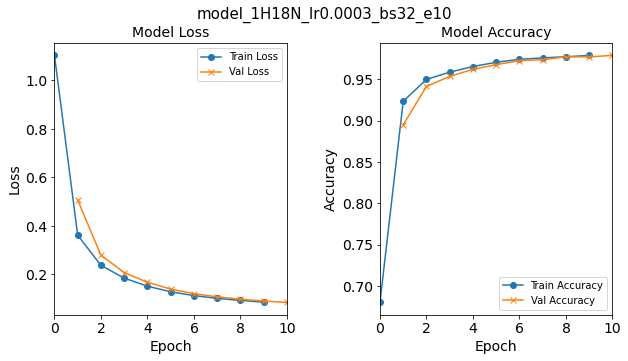

In [61]:
# save the outputs
saveOutputs_LR(0.0003, model_1H18N_LR0_0003_history, model_1H18N_LR0_0003)

**TODO**

... (create additional code cells to run models (`1H18N`) with larger learning rates: **0.001**, **0.01**,**0.1**)

##### Model "1H18N" With Learning Rate 0.001

In [62]:
#RUNIT
# Reproducibility hacks!

np.random.seed(31254389)
tf.random.set_seed(49358903)

In [63]:
"""Construct & train a NN_Model_1H with 18 neurons in the hidden layer & learning rate=0.001""";


model_1H18N_LR0_001 = NN_Model_1H(18,0.001)
model_1H18N_LR0_001_history = model_1H18N_LR0_001.fit(train_features,
                                      train_L_onehot,
                                      epochs=10, batch_size=32,
                                      validation_data=(val_features, val_L_onehot),
                                      verbose=2)

Created model: NN_Model_1H
 - hidden_layers  = 1
 - hidden_neurons = 18
 - optimizer      = Adam
 - learning_rate  = 0.001

Epoch 1/10
6827/6827 - 6s - loss: 0.5687 - accuracy: 0.8485 - val_loss: 0.2241 - val_accuracy: 0.9488
Epoch 2/10
6827/6827 - 6s - loss: 0.1676 - accuracy: 0.9621 - val_loss: 0.1305 - val_accuracy: 0.9677
Epoch 3/10
6827/6827 - 7s - loss: 0.1106 - accuracy: 0.9740 - val_loss: 0.0954 - val_accuracy: 0.9750
Epoch 4/10
6827/6827 - 6s - loss: 0.0856 - accuracy: 0.9785 - val_loss: 0.0769 - val_accuracy: 0.9804
Epoch 5/10
6827/6827 - 6s - loss: 0.0712 - accuracy: 0.9827 - val_loss: 0.0656 - val_accuracy: 0.9829
Epoch 6/10
6827/6827 - 6s - loss: 0.0607 - accuracy: 0.9860 - val_loss: 0.0548 - val_accuracy: 0.9886
Epoch 7/10
6827/6827 - 6s - loss: 0.0523 - accuracy: 0.9884 - val_loss: 0.0507 - val_accuracy: 0.9893
Epoch 8/10
6827/6827 - 7s - loss: 0.0467 - accuracy: 0.9896 - val_loss: 0.0450 - val_accuracy: 0.9891
Epoch 9/10
6827/6827 - 6s - loss: 0.0418 - accuracy: 0.9903 

In [64]:
#AdvMetadataVersion
# metadata for the model - (Expt_ID, Job_ID, hidden_neurons, learning_rate, batch_size, epoch)
model_1H18N_LR0_001_data = ('lr0.001-lr', 9, '[18]', 0.001, 32, 10) 

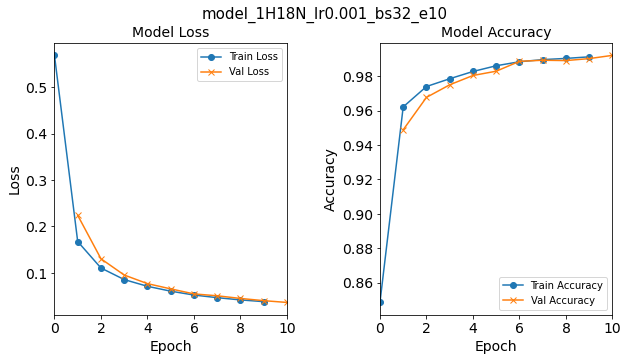

In [65]:
# save the outputs
saveOutputs_LR(0.001, model_1H18N_LR0_001_history, model_1H18N_LR0_001)

##### Model "1H18N" With Learning Rate 0.01

In [66]:
#RUNIT
# Reproducibility hacks!

np.random.seed(78642393)
tf.random.set_seed(45273894)

In [67]:
"""Construct & train a NN_Model_1H with 18 neurons in the hidden layer & learning rate=0.01""";


model_1H18N_LR0_01 = NN_Model_1H(18,0.01)
model_1H18N_LR0_01_history = model_1H18N_LR0_01.fit(train_features,
                                      train_L_onehot,
                                      epochs=10, batch_size=32,
                                      validation_data=(val_features, val_L_onehot),
                                      verbose=2)

Created model: NN_Model_1H
 - hidden_layers  = 1
 - hidden_neurons = 18
 - optimizer      = Adam
 - learning_rate  = 0.01

Epoch 1/10
6827/6827 - 6s - loss: 0.1862 - accuracy: 0.9504 - val_loss: 0.0835 - val_accuracy: 0.9769
Epoch 2/10
6827/6827 - 6s - loss: 0.0659 - accuracy: 0.9841 - val_loss: 0.0459 - val_accuracy: 0.9903
Epoch 3/10
6827/6827 - 6s - loss: 0.0500 - accuracy: 0.9884 - val_loss: 0.0506 - val_accuracy: 0.9860
Epoch 4/10
6827/6827 - 6s - loss: 0.0428 - accuracy: 0.9899 - val_loss: 0.0575 - val_accuracy: 0.9907
Epoch 5/10
6827/6827 - 6s - loss: 0.0395 - accuracy: 0.9904 - val_loss: 0.0441 - val_accuracy: 0.9919
Epoch 6/10
6827/6827 - 6s - loss: 0.0381 - accuracy: 0.9918 - val_loss: 0.0311 - val_accuracy: 0.9936
Epoch 7/10
6827/6827 - 6s - loss: 0.0354 - accuracy: 0.9919 - val_loss: 0.0367 - val_accuracy: 0.9894
Epoch 8/10
6827/6827 - 6s - loss: 0.0333 - accuracy: 0.9924 - val_loss: 0.0276 - val_accuracy: 0.9931
Epoch 9/10
6827/6827 - 6s - loss: 0.0312 - accuracy: 0.9927 -

In [68]:
#AdvMetadataVersion
# metadata for the model - (Expt_ID, Job_ID, hidden_neurons, learning_rate, batch_size, epoch)
model_1H18N_LR0_01_data = ('lr0.01-lr', 10, '[18]', 0.01, 32, 10) 

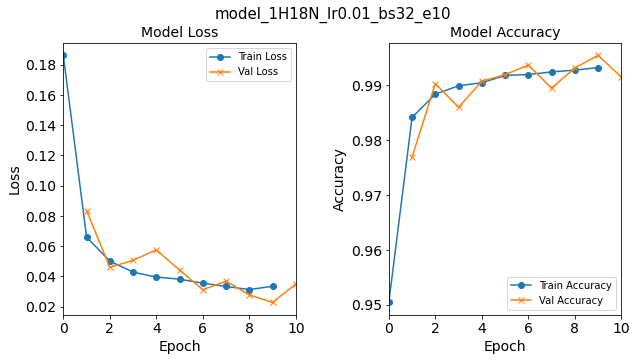

In [69]:
# save the outputs
saveOutputs_LR(0.01, model_1H18N_LR0_01_history, model_1H18N_LR0_01)

##### Model "1H18N" With Learning Rate 0.1

In [70]:
#RUNIT
# Reproducibility hacks!

np.random.seed(5823332)
tf.random.set_seed(198173894)

In [71]:
"""Construct & train a NN_Model_1H with 18 neurons in the hidden layer & learning rate=0.1""";


model_1H18N_LR0_1 = NN_Model_1H(18,0.1)
model_1H18N_LR0_1_history = model_1H18N_LR0_1.fit(train_features,
                                      train_L_onehot,
                                      epochs=10, batch_size=32,
                                      validation_data=(val_features, val_L_onehot),
                                      verbose=2)

Created model: NN_Model_1H
 - hidden_layers  = 1
 - hidden_neurons = 18
 - optimizer      = Adam
 - learning_rate  = 0.1

Epoch 1/10
6827/6827 - 6s - loss: 0.4806 - accuracy: 0.9238 - val_loss: 0.2683 - val_accuracy: 0.9397
Epoch 2/10
6827/6827 - 6s - loss: 0.2867 - accuracy: 0.9343 - val_loss: 0.2972 - val_accuracy: 0.9402
Epoch 3/10
6827/6827 - 6s - loss: 0.4591 - accuracy: 0.9364 - val_loss: 0.2503 - val_accuracy: 0.9670
Epoch 4/10
6827/6827 - 6s - loss: 0.5727 - accuracy: 0.9405 - val_loss: 0.9521 - val_accuracy: 0.9330
Epoch 5/10
6827/6827 - 6s - loss: 0.3540 - accuracy: 0.9367 - val_loss: 0.2588 - val_accuracy: 0.9394
Epoch 6/10
6827/6827 - 6s - loss: 0.3486 - accuracy: 0.9334 - val_loss: 0.4348 - val_accuracy: 0.9317
Epoch 7/10
6827/6827 - 6s - loss: 0.4706 - accuracy: 0.9351 - val_loss: 0.3515 - val_accuracy: 0.9147
Epoch 8/10
6827/6827 - 6s - loss: 0.3282 - accuracy: 0.9322 - val_loss: 0.2421 - val_accuracy: 0.9375
Epoch 9/10
6827/6827 - 6s - loss: 0.3283 - accuracy: 0.9327 - 

In [72]:
#AdvMetadataVersion
# metadata for the model - (Expt_ID, Job_ID, hidden_neurons, learning_rate, batch_size, epoch)
model_1H18N_LR0_1_data = ('lr0.1-lr', 11, '[18]', 0.1, 32, 10) 

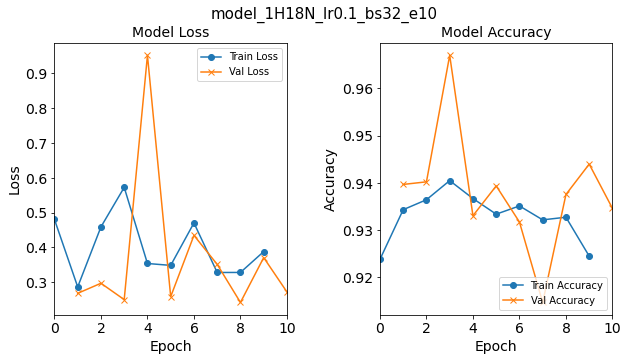

In [73]:
# save the outputs
saveOutputs_LR(0.1, model_1H18N_LR0_1_history, model_1H18N_LR0_1)

#### Post Processing for Experiment Type 2: Learning Rate

##### Visual inspection of graphs:

Both 0.01 and 0.1 LR loss and accuracy graphs do not follow the typical trend.
The 0.1 LR deviates a lot from the typical loss and accuracy plot trends!

#### Post Processing (Compiling the CSV) for Experiment Type 2: Learning Rate

This follows the same format as the hidden neurons with different variable names.
See above for more information.

In [49]:
# outer directory
dirPathLR = dir0_LR

# The learning rates for each experiment/model
listLR = [.0003, 0.001, 0.01, 0.1]

# Number of epochs - 1
lastEpochNum = 9 

# Initalize. This will hold the list of dictionaries of last epoch metrics
# (loss, val_loss, accuracy, val_accuracy)
all_lastEpochMetrics_LR = []

# Fill in the rows for the DataFrame
for LR in listLR:
    # Read the history CSV file and get the last row's data, which corresponds to the last epoch data.
    # run_subdir = "model_1H18N_lr"+str(LR)+"_bs32_e10"
    # result_csv = os.path.join(dirPathHN, run_subdir, "model_history.csv")
    result_csv = fn_out_history_1H(dirPathLR, 18, LR, 32, lastEpochNum+1)
    print("Reading:", result_csv)
    epochMetrics = pd.read_csv(result_csv)
    # Fetch the loss, accuracy, val_loss, and val_accuracy from the last epoch
    # (should be the last row in the CSV file unless there's something wrong
    # during the traning)
    lastEpochMetrics = epochMetrics.iloc[lastEpochNum, :].to_dict()
    # Attach the "learning rate" value
    lastEpochMetrics["learning_rate"] = LR
    all_lastEpochMetrics_LR.append(lastEpochMetrics)

Reading: scan-learning-rate/model_1H18N_lr0.0003_bs32_e10/model_history.csv
Reading: scan-learning-rate/model_1H18N_lr0.001_bs32_e10/model_history.csv
Reading: scan-learning-rate/model_1H18N_lr0.01_bs32_e10/model_history.csv
Reading: scan-learning-rate/model_1H18N_lr0.1_bs32_e10/model_history.csv


Now construct the `df_LR` dataframe:

In [50]:
df_LR = pd.DataFrame(all_lastEpochMetrics_LR, 
                     columns=["learning_rate", "loss", "accuracy", "val_loss", "val_accuracy"])

In [51]:
print(df_LR)

   learning_rate      loss  accuracy  val_loss  val_accuracy
0         0.0003  0.085931  0.978687  0.084746      0.978816
1         0.0010  0.038100  0.991234  0.036374      0.992090
2         0.0100  0.033377  0.993193  0.034927      0.991486
3         0.1000  0.388289  0.924485  0.272247      0.934598


##### Save the post-processing results for the learning rate experiments

In [52]:
df_LR.to_csv("post_processing_lr.csv", index=False)

In [55]:
# #AdvMetadataVersion
# def createDataFrame(metaData, histories):
#     dfs = []
#     for i in range(len(histories)):
#         # Create the DataFrame with the initial history values.
#         # This will fill in the loss, accuracy, val_loss, val_accuracy columns.
#         df = pd.DataFrame(histories[i].history, columns = \
#                           ['Expt_ID', 'Job_ID', 'hidden_neurons', 'learning_rate', 'batch_size', \
#                            'epoch', "loss", "accuracy", "val_loss", "val_accuracy"])
#         # Assign the corresponding metadata columns
#         df.iloc[:, 0:5] = metaData[i][0:5]
#         df.iloc[:, 5] = range(metaData[i][5])

#         # Make sure the data types are correct
#         df['Job_ID'] = df['Job_ID'].astype(int)
#         df['epoch'] = df['epoch'].astype(int)
#         df['batch_size'] = df['batch_size'].astype(int)

#         dfs.append(df)

#     # Combine the DataFrames
#     fullDF = pd.concat(dfs)
#     # reset the index so that it corresponds to the row number
#     fullDF.reset_index(drop=True, inplace=True) 
#     return fullDF

# # collect the history and metadata information
# histories = [model_1H18N_LR0_0003_history, model_1H18N_LR0_001_history, \
#              model_1H18N_LR0_01_history, model_1H18N_LR0_1_history]
# metaData = [model_1H18N_LR0_0003_data, model_1H18N_LR0_001_data, \
#             model_1H18N_LR0_01_data, model_1H18N_LR0_1_data]
# df = createDataFrame(metaData, histories)

# print(df) 
# df.to_csv("post_processing_lr1.csv", index=False)

### 4.3 Tuning Experiments #3: Varying Batch Size

The accuracy and loss of each model will be compared while changing the 'batch size'.
For simplicity, all other parameters (e.g. learning rate, epochs, number of neurons, hidden layers) will be kept constant.
The one hidden layer with 18 neurons model will be used.
Not every number of batch size is included, so feel free to create new code cells with a different number of batch size.

##### Define the helper function

In [56]:
# Create the outer batch_size directory
dir0_BS = "scan-batch-size"
if not os.path.exists(dir0_BS):
        os.makedirs(dir0_BS)

## Helper function

def saveOutputs_BS(batch_size, currHistory, currModel):
    """
    Save the outputs of the batch size model tuning experiments.
    It will create a directory within the batch size directory with the 
    MODEL_DIR name.
    Save within this folder the following: 
    1. A loss_acc_plot.png that is the training and validation loss vs. epochs
      and the training and validation accuracy vs. epochs graphs.
    2. model_history.csv that contains the training and validation loss and
      accuracy per epoch data.
    3. model_weights.h5 that contains the saved model.
    
    Args:
      batch_size: the batch size used in this experiment.
      currHistory: the current history object used to create (and then save) the CSV and plot files.
      currModel: the current model to save.
    
    """
    # Create model output directory
    model_name = "model_1H18N_lr0.0003_bs" + str(batch_size) + "_e" + str(10)
    MODEL_DIR = "model_tuning/batch_size/"+model_name
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)

    ## Save the Output

    # Utilize os.path.join to add the output files to the MODEL_DIR defined above.
    history_file = os.path.join(MODEL_DIR, 'model_history.csv')
    plot_file = os.path.join(MODEL_DIR, 'loss_acc_plot.png')
    model_file = os.path.join(MODEL_DIR, 'model_weights.h5')

    # save the history into a CSV file
    history_df = pd.DataFrame(currHistory.history)
    history_df.to_csv(history_file, index=False)

    # save the plots using the toolbox function and then add a title
    combine_loss_acc_plots(currHistory, plot_loss, plot_acc, show=False)
    plt.suptitle(model_name, fontsize=15)
    plt.savefig(plot_file)

    # save the model
    currModel.save(model_file)

**TODO**

... (create additional code cells to run models (`1H18N`) with larger batch sizes, e.g. 16, 32, 64, 128, 512, 1024, ...).
Remember that we have the original batch_size=16.

##### Model "1H18N" With Batch Size 16

In [82]:
#RUNIT
# Reproducibility hacks!

np.random.seed(968172)
tf.random.set_seed(83018241)

In [83]:
"""Construct & train a NN_Model_1H with 18 neurons in the hidden layer & batch size=16""";

model_1H18N_BS16 = NN_Model_1H(18,0.0003)
model_1H18N_BS16_history = model_1H18N_BS16.fit(train_features,
                                      train_L_onehot,
                                      epochs=10, batch_size=16,
                                      validation_data=(val_features, val_L_onehot),
                                      verbose=2)

Created model: NN_Model_1H
 - hidden_layers  = 1
 - hidden_neurons = 18
 - optimizer      = Adam
 - learning_rate  = 0.0003

Epoch 1/10
13654/13654 - 12s - loss: 0.8238 - accuracy: 0.7727 - val_loss: 0.3321 - val_accuracy: 0.9270
Epoch 2/10
13654/13654 - 12s - loss: 0.2556 - accuracy: 0.9389 - val_loss: 0.2078 - val_accuracy: 0.9495
Epoch 3/10
13654/13654 - 12s - loss: 0.1765 - accuracy: 0.9567 - val_loss: 0.1512 - val_accuracy: 0.9634
Epoch 4/10
13654/13654 - 12s - loss: 0.1350 - accuracy: 0.9688 - val_loss: 0.1211 - val_accuracy: 0.9720
Epoch 5/10
13654/13654 - 12s - loss: 0.1113 - accuracy: 0.9748 - val_loss: 0.1021 - val_accuracy: 0.9773
Epoch 6/10
13654/13654 - 12s - loss: 0.0962 - accuracy: 0.9792 - val_loss: 0.0899 - val_accuracy: 0.9811
Epoch 7/10
13654/13654 - 14s - loss: 0.0850 - accuracy: 0.9815 - val_loss: 0.0809 - val_accuracy: 0.9824
Epoch 8/10
13654/13654 - 12s - loss: 0.0767 - accuracy: 0.9829 - val_loss: 0.0734 - val_accuracy: 0.9826
Epoch 9/10
13654/13654 - 12s - loss

In [84]:
#AdvMetadataVersion
# metadata for the model - (Expt_ID, Job_ID, hidden_neurons, learning_rate, batch_size, epoch)
model_1H18N_BS16_data = ('bs16-batch', 12, '[18]', 0.0003, 16, 10) 

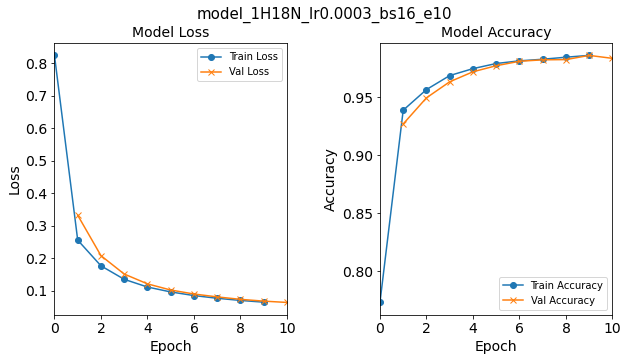

In [85]:
# save the outputs
saveOutputs_BS(16, model_1H18N_BS16_history, model_1H18N_BS16)

##### Model "1H18N" With Batch Size 32

In [86]:
#RUNIT
# Reproducibility hacks!

np.random.seed(968172)
tf.random.set_seed(83018241)

In [87]:
"""Construct & train a NN_Model_1H with 18 neurons in the hidden layer & batch size=32""";

model_1H18N_BS32 = NN_Model_1H(18,0.0003)
model_1H18N_BS32_history = model_1H18N_BS32.fit(train_features,
                                      train_L_onehot,
                                      epochs=10, batch_size=32,
                                      validation_data=(val_features, val_L_onehot),
                                      verbose=2)

Created model: NN_Model_1H
 - hidden_layers  = 1
 - hidden_neurons = 18
 - optimizer      = Adam
 - learning_rate  = 0.0003

Epoch 1/10
6827/6827 - 6s - loss: 1.1029 - accuracy: 0.6803 - val_loss: 0.5063 - val_accuracy: 0.8949
Epoch 2/10
6827/6827 - 6s - loss: 0.3616 - accuracy: 0.9233 - val_loss: 0.2791 - val_accuracy: 0.9413
Epoch 3/10
6827/6827 - 6s - loss: 0.2377 - accuracy: 0.9498 - val_loss: 0.2081 - val_accuracy: 0.9534
Epoch 4/10
6827/6827 - 6s - loss: 0.1850 - accuracy: 0.9585 - val_loss: 0.1679 - val_accuracy: 0.9620
Epoch 5/10
6827/6827 - 6s - loss: 0.1517 - accuracy: 0.9653 - val_loss: 0.1397 - val_accuracy: 0.9676
Epoch 6/10
6827/6827 - 6s - loss: 0.1287 - accuracy: 0.9705 - val_loss: 0.1209 - val_accuracy: 0.9725
Epoch 7/10
6827/6827 - 6s - loss: 0.1129 - accuracy: 0.9741 - val_loss: 0.1079 - val_accuracy: 0.9736
Epoch 8/10
6827/6827 - 6s - loss: 0.1016 - accuracy: 0.9757 - val_loss: 0.0982 - val_accuracy: 0.9770
Epoch 9/10
6827/6827 - 6s - loss: 0.0929 - accuracy: 0.9772

In [88]:
#AdvMetadataVersion
# metadata for the model - (Expt_ID, Job_ID, hidden_neurons, learning_rate, batch_size, epoch)
model_1H18N_BS32_data = ('bs32-batch', 13, '[18]', 0.0003, 32, 10) 

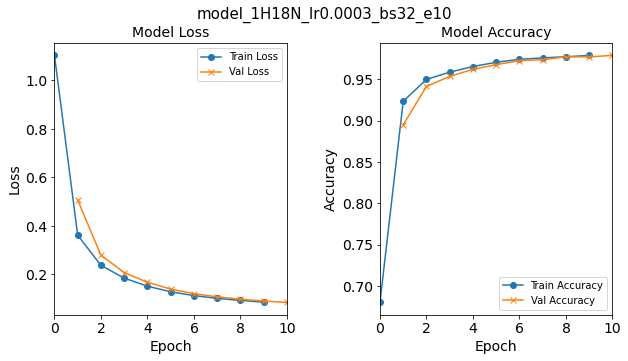

In [89]:
# save the outputs
saveOutputs_BS(32, model_1H18N_BS32_history, model_1H18N_BS32)

##### Model "1H18N" With Batch Size 64

In [92]:
#RUNIT
# Reproducibility hacks!

np.random.seed(968172)
tf.random.set_seed(83018241)

In [93]:
"""Construct & train a NN_Model_1H with 18 neurons in the hidden layer & batch size=64""";

model_1H18N_BS64 = NN_Model_1H(18,0.0003)
model_1H18N_BS64_history = model_1H18N_BS64.fit(train_features,
                                      train_L_onehot,
                                      epochs=10, batch_size=64,
                                      validation_data=(val_features, val_L_onehot),
                                      verbose=2)

Created model: NN_Model_1H
 - hidden_layers  = 1
 - hidden_neurons = 18
 - optimizer      = Adam
 - learning_rate  = 0.0003

Epoch 1/10
3414/3414 - 3s - loss: 1.4388 - accuracy: 0.5565 - val_loss: 0.8041 - val_accuracy: 0.7991
Epoch 2/10
3414/3414 - 4s - loss: 0.5776 - accuracy: 0.8707 - val_loss: 0.4256 - val_accuracy: 0.9052
Epoch 3/10
3414/3414 - 3s - loss: 0.3546 - accuracy: 0.9216 - val_loss: 0.3060 - val_accuracy: 0.9325
Epoch 4/10
3414/3414 - 3s - loss: 0.2738 - accuracy: 0.9401 - val_loss: 0.2500 - val_accuracy: 0.9453
Epoch 5/10
3414/3414 - 3s - loss: 0.2294 - accuracy: 0.9504 - val_loss: 0.2141 - val_accuracy: 0.9519
Epoch 6/10
3414/3414 - 3s - loss: 0.1987 - accuracy: 0.9556 - val_loss: 0.1875 - val_accuracy: 0.9568
Epoch 7/10
3414/3414 - 3s - loss: 0.1750 - accuracy: 0.9597 - val_loss: 0.1665 - val_accuracy: 0.9612
Epoch 8/10
3414/3414 - 3s - loss: 0.1554 - accuracy: 0.9637 - val_loss: 0.1490 - val_accuracy: 0.9654
Epoch 9/10
3414/3414 - 3s - loss: 0.1397 - accuracy: 0.9671

In [94]:
#AdvMetadataVersion

# metadata for the model - (Expt_ID, Job_ID, hidden_neurons, learning_rate, batch_size, epoch)
model_1H18N_BS64_data = ('bs64-batch', 14, '[18]', 0.0003, 64, 10) 

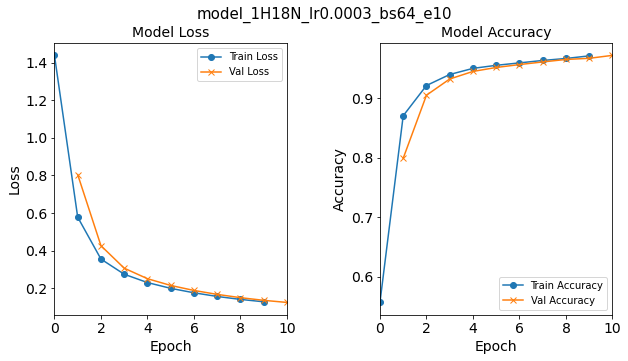

In [95]:
# save the outputs
saveOutputs_BS(64, model_1H18N_BS64_history, model_1H18N_BS64)

##### Model "1H18N" With Batch Size 128

In [96]:
#RUNIT
# Reproducibility hacks!

np.random.seed(968172)
tf.random.set_seed(83018241)

In [97]:
"""Construct & train a NN_Model_1H with 18 neurons in the hidden layer & batch size=128""";

model_1H18N_BS128 = NN_Model_1H(18,0.0003)
model_1H18N_BS128_history = model_1H18N_BS128.fit(train_features,
                                      train_L_onehot,
                                      epochs=10, batch_size=128,
                                      validation_data=(val_features, val_L_onehot),
                                      verbose=2)

Created model: NN_Model_1H
 - hidden_layers  = 1
 - hidden_neurons = 18
 - optimizer      = Adam
 - learning_rate  = 0.0003

Epoch 1/10
1707/1707 - 2s - loss: 1.8142 - accuracy: 0.4222 - val_loss: 1.1781 - val_accuracy: 0.6166
Epoch 2/10
1707/1707 - 2s - loss: 0.9118 - accuracy: 0.7627 - val_loss: 0.7089 - val_accuracy: 0.8346
Epoch 3/10
1707/1707 - 2s - loss: 0.5814 - accuracy: 0.8680 - val_loss: 0.4835 - val_accuracy: 0.8870
Epoch 4/10
1707/1707 - 2s - loss: 0.4178 - accuracy: 0.8995 - val_loss: 0.3700 - val_accuracy: 0.9097
Epoch 5/10
1707/1707 - 2s - loss: 0.3344 - accuracy: 0.9209 - val_loss: 0.3081 - val_accuracy: 0.9280
Epoch 6/10
1707/1707 - 2s - loss: 0.2854 - accuracy: 0.9337 - val_loss: 0.2688 - val_accuracy: 0.9384
Epoch 7/10
1707/1707 - 2s - loss: 0.2521 - accuracy: 0.9426 - val_loss: 0.2398 - val_accuracy: 0.9471
Epoch 8/10
1707/1707 - 2s - loss: 0.2262 - accuracy: 0.9491 - val_loss: 0.2164 - val_accuracy: 0.9505
Epoch 9/10
1707/1707 - 2s - loss: 0.2052 - accuracy: 0.9528

In [98]:
#AdvMetadataVersion

# metadata for the model - (Expt_ID, Job_ID, hidden_neurons, learning_rate, batch_size, epoch)
model_1H18N_BS128_data = ('bs128-batch', 15, '[18]', 0.0003, 128, 10) 

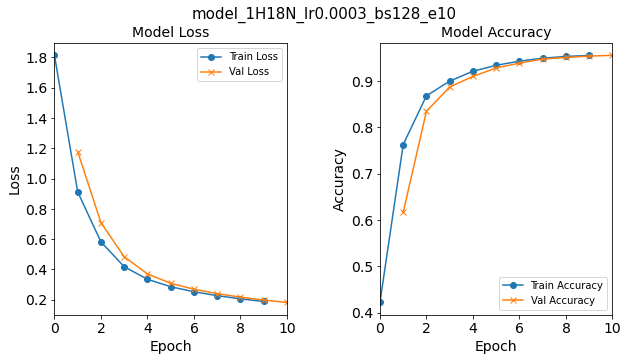

In [99]:
# save the outputs
saveOutputs_BS(128, model_1H18N_BS128_history, model_1H18N_BS128)

##### Model "1H18N" With Batch Size 512

In [101]:
#RUNIT
# Reproducibility hacks!

np.random.seed(968172)
tf.random.set_seed(83018241)

In [102]:
"""Construct & train a NN_Model_1H with 18 neurons in the hidden layer & batch size=512""";

model_1H18N_BS512 = NN_Model_1H(18,0.0003)
model_1H18N_BS512_history = model_1H18N_BS512.fit(train_features,
                                      train_L_onehot,
                                      epochs=10, batch_size=512,
                                      validation_data=(val_features, val_L_onehot),
                                      verbose=2)

Created model: NN_Model_1H
 - hidden_layers  = 1
 - hidden_neurons = 18
 - optimizer      = Adam
 - learning_rate  = 0.0003

Epoch 1/10
427/427 - 1s - loss: 2.5478 - accuracy: 0.2648 - val_loss: 2.0955 - val_accuracy: 0.3152
Epoch 2/10
427/427 - 1s - loss: 1.8088 - accuracy: 0.4025 - val_loss: 1.5753 - val_accuracy: 0.4566
Epoch 3/10
427/427 - 1s - loss: 1.4084 - accuracy: 0.5331 - val_loss: 1.2653 - val_accuracy: 0.5890
Epoch 4/10
427/427 - 1s - loss: 1.1491 - accuracy: 0.6474 - val_loss: 1.0477 - val_accuracy: 0.6946
Epoch 5/10
427/427 - 1s - loss: 0.9598 - accuracy: 0.7376 - val_loss: 0.8844 - val_accuracy: 0.7828
Epoch 6/10
427/427 - 1s - loss: 0.8154 - accuracy: 0.8087 - val_loss: 0.7568 - val_accuracy: 0.8250
Epoch 7/10
427/427 - 1s - loss: 0.6995 - accuracy: 0.8407 - val_loss: 0.6515 - val_accuracy: 0.8484
Epoch 8/10
427/427 - 1s - loss: 0.6063 - accuracy: 0.8697 - val_loss: 0.5704 - val_accuracy: 0.8790
Epoch 9/10
427/427 - 1s - loss: 0.5349 - accuracy: 0.8828 - val_loss: 0.507

In [103]:
#AdvMetadataVersion
# metadata for the model - (Expt_ID, Job_ID, hidden_neurons, learning_rate, batch_size, epoch)
model_1H18N_BS512_data = ('bs512-batch', 16, '[18]', 0.0003, 512, 10) 

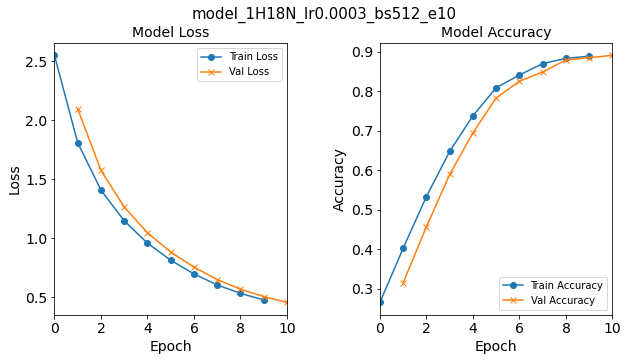

In [104]:
# save the outputs
saveOutputs_BS(512, model_1H18N_BS512_history, model_1H18N_BS512)

##### Model "1H18N" With Batch Size 1024

In [105]:
#RUNIT
# Reproducibility hacks!

np.random.seed(968172)
tf.random.set_seed(83018241)

In [106]:
"""Construct & train a NN_Model_1H with 18 neurons in the hidden layer & batch size=1024""";

model_1H18N_BS1024 = NN_Model_1H(18,0.0003)
model_1H18N_BS1024_history = model_1H18N_BS1024.fit(train_features,
                                      train_L_onehot,
                                      epochs=10, batch_size=1024,
                                      validation_data=(val_features, val_L_onehot),
                                      verbose=2)

Created model: NN_Model_1H
 - hidden_layers  = 1
 - hidden_neurons = 18
 - optimizer      = Adam
 - learning_rate  = 0.0003

Epoch 1/10
214/214 - 1s - loss: 2.7688 - accuracy: 0.2434 - val_loss: 2.5636 - val_accuracy: 0.3167
Epoch 2/10
214/214 - 0s - loss: 2.3085 - accuracy: 0.3085 - val_loss: 2.0787 - val_accuracy: 0.3201
Epoch 3/10
214/214 - 0s - loss: 1.9158 - accuracy: 0.3856 - val_loss: 1.7679 - val_accuracy: 0.4188
Epoch 4/10
214/214 - 0s - loss: 1.6514 - accuracy: 0.4357 - val_loss: 1.5421 - val_accuracy: 0.4649
Epoch 5/10
214/214 - 0s - loss: 1.4515 - accuracy: 0.5100 - val_loss: 1.3691 - val_accuracy: 0.5613
Epoch 6/10
214/214 - 0s - loss: 1.2958 - accuracy: 0.5860 - val_loss: 1.2295 - val_accuracy: 0.6109
Epoch 7/10
214/214 - 0s - loss: 1.1667 - accuracy: 0.6487 - val_loss: 1.1110 - val_accuracy: 0.6735
Epoch 8/10
214/214 - 0s - loss: 1.0568 - accuracy: 0.6860 - val_loss: 1.0103 - val_accuracy: 0.7002
Epoch 9/10
214/214 - 0s - loss: 0.9632 - accuracy: 0.7167 - val_loss: 0.923

In [109]:
#AdvMetadataVersion
# metadata for the model - (Expt_ID, Job_ID, hidden_neurons, learning_rate, batch_size, epoch)
model_1H18N_BS1024_data = ('bs1024-batch', 17, '[18]', 0.0003, 1024, 10) 

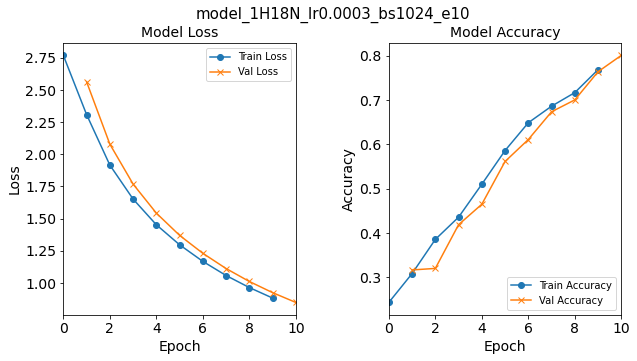

In [108]:
# save the outputs
saveOutputs_BS(1024, model_1H18N_BS1024_history, model_1H18N_BS1024)

#### Post Processing for Experiment Type 3: Batch Size

##### Visual inspection of graphs:

Batch sizes of 128, 512, and 1024 loss and accuracy graphs do not follow the typical trend.
The graphs from 128 start deviating from the usual trend, with 512 and 1024 deviating even more.

#### Post Processing (Compiling the CSV) for Experiment Type 3: Batch Size

This follows the same format as the hidden neurons with different variable names.
See above for more information.

In [57]:
# outer directory
dirPathLR = dir0_BS

# The batch sizes for each experiment/model
listBS = [16, 32, 64, 128, 512, 1024]

# Number of epochs - 1
lastEpochNum = 9 

# Initalize. This will hold the list of dictionaries of last epoch metrics
# (loss, val_loss, accuracy, val_accuracy)
all_lastEpochMetrics_BS = []

# Fill in the rows for the DataFrame
for BS in listBS:
    # Read the history CSV file and get the last row's data, which corresponds to the last epoch data.
    # run_subdir = "model_1H18N_lr0.0003_bs"+str(BS)+"_e10"
    # result_csv = os.path.join(dirPathHN, run_subdir, "model_history.csv")
    result_csv = fn_out_history_1H(dirPathLR, 18, 0.0003, BS, lastEpochNum+1)
    print("Reading:", result_csv)
    epochMetrics = pd.read_csv(result_csv)
    # Fetch the loss, accuracy, val_loss, and val_accuracy from the last epoch
    # (should be the last row in the CSV file unless there's something wrong
    # during the traning)
    lastEpochMetrics = epochMetrics.iloc[lastEpochNum, :].to_dict()
    # Attach the "batch size" value
    lastEpochMetrics["batch_size"] = BS
    all_lastEpochMetrics_BS.append(lastEpochMetrics)

Reading: scan-batch-size/model_1H18N_lr0.0003_bs16_e10/model_history.csv
Reading: scan-batch-size/model_1H18N_lr0.0003_bs32_e10/model_history.csv
Reading: scan-batch-size/model_1H18N_lr0.0003_bs64_e10/model_history.csv
Reading: scan-batch-size/model_1H18N_lr0.0003_bs128_e10/model_history.csv
Reading: scan-batch-size/model_1H18N_lr0.0003_bs512_e10/model_history.csv
Reading: scan-batch-size/model_1H18N_lr0.0003_bs1024_e10/model_history.csv


Now construct the `df_BS` dataframe:

In [58]:
df_BS = pd.DataFrame(all_lastEpochMetrics_BS, 
                     columns=["batch_size", "loss", "accuracy", "val_loss", "val_accuracy"])

In [59]:
print(df_BS)

   batch_size      loss  accuracy  val_loss  val_accuracy
0          16  0.064712  0.986249  0.063871      0.983649
1          32  0.085931  0.978687  0.084746      0.978816
2          64  0.127095  0.971469  0.123601      0.972334
3         128  0.187915  0.954985  0.181421      0.955123
4         512  0.479190  0.888735  0.458066      0.890581
5        1024  0.881485  0.768403  0.847284      0.800645


##### Save the post-processing results for the batch size experiments

In [61]:
df_BS.to_csv("post_processing_bs.csv", index=False)

In [62]:
# #AdvMetadataVersion

# # collect the history and metadata information
# histories = [model_1H18N_BS16_history, model_1H18N_BS32_history, model_1H18N_BS64_history, \
#              model_1H18N_BS128_history, model_1H18N_BS512_history, model_1H18N_BS1024_history]
# metaData = [model_1H18N_BS16_data, model_1H18N_BS32_data, model_1H18N_BS64_data, \
#             model_1H18N_BS128_data, model_1H18N_BS512_data, model_1H18N_BS1024_data]
# df = createDataFrame(metaData, histories)

# print(df) 
# df.to_csv("post_processing_bs.csv", index=False)

### 4.4 Tuning Experiments #4: Varying the number of hidden layers

The accuracy and loss of each model will be compared while changing the 'number of hidden layers'.
For simplicity, all other parameters (e.g. learning rate, epochs, batch_size, number of neurons) will be kept constant.
Not every number of hidden layers is included, so feel free to create new code cells with a different number of layers.

##### Define the helper function

In [63]:
# Create the outer layers directory
dir0_HL = "scan-layers"
if not os.path.exists(dir0_HL):
        os.makedirs(dir0_HL)

## Helper function

def saveOutputs_HL(num_layers, currHistory, currModel):
    """
    Save the outputs of the multiple hidden layers model tuning experiments.
    It will create a directory within the layers directory with the 
    MODEL_DIR name.
    Save within this folder the following: 
    1. A loss_acc_plot.png that is the training and validation loss vs. epochs
      and the training and validation accuracy vs. epochs graphs.
    2. model_history.csv that contains the training and validation loss and
      accuracy per epoch data.
    3. model_weights.h5 that contains the saved model.
    
    Args:
      num_layers: the number of hidden layers used in this experiment.
      currHistory: the current history object used to create (and then save) the CSV and plot files.
      currModel: the current model to save.
    
    """
    # Create model output directory
    titleAdd = str(num_layers) + "H"
    for j in range(num_layers):
        titleAdd += "18N"
    model_name = "model_"+titleAdd+"_lr0.0003_bs32" + "_e" + str(10)
    MODEL_DIR = "model_tuning/layers/"+model_name
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)

    ## Save the Output

    # Utilize os.path.join to add the output files to the MODEL_DIR defined above.
    history_file = os.path.join(MODEL_DIR, 'model_history.csv')
    plot_file = os.path.join(MODEL_DIR, 'loss_acc_plot.png')
    model_file = os.path.join(MODEL_DIR, 'model_weights.h5')

    # save the history into a CSV file
    history_df = pd.DataFrame(currHistory.history)
    history_df.to_csv(history_file, index=False)

    # save the plots using the toolbox function and then add a title
    combine_loss_acc_plots(currHistory, plot_loss, plot_acc, show=False)
    plt.suptitle(model_name, fontsize=15)
    plt.savefig(plot_file)

    # save the model
    currModel.save(model_file)

#### Create the NN_Model_2H function that will build and compile a model with 2 hidden layers

In [119]:
def NN_Model_2H(hidden_neurons_1,sec_hidden_neurons_1, learning_rate):
    """Definition of deep learning model with two dense hidden layers"""
    random_normal_init = tf.random_normal_initializer(mean=0.0, stddev=0.05)
    model = Sequential([
        # More hidden layers can be added here
        Dense(hidden_neurons_1, activation='relu', input_shape=(19,),
              kernel_initializer=random_normal_init), # Hidden Layer
        Dense(hidden_neurons_1, activation='relu', 
              kernel_initializer=random_normal_init), # Hidden Layer
        Dense(18, activation='softmax',
              kernel_initializer=random_normal_init)  # Output Layer
    ])
    adam_opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam_opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [120]:
#RUNIT
# Reproducibility hacks!

np.random.seed(968172)
tf.random.set_seed(83018241)

In [121]:
# the model with 18 neurons in both of the hidden layers
model_2H18N18N = NN_Model_2H(18,18,0.0003)
model_2H18N18N_history = model_2H18N18N.fit(train_features,
                                      train_L_onehot,
                                      epochs=10, batch_size=32,
                                      validation_data=(val_features, val_L_onehot),
                                      verbose=2)

Epoch 1/10
6827/6827 - 7s - loss: 1.0831 - accuracy: 0.6562 - val_loss: 0.4132 - val_accuracy: 0.8995
Epoch 2/10
6827/6827 - 6s - loss: 0.3015 - accuracy: 0.9291 - val_loss: 0.2293 - val_accuracy: 0.9455
Epoch 3/10
6827/6827 - 8s - loss: 0.1910 - accuracy: 0.9538 - val_loss: 0.1597 - val_accuracy: 0.9603
Epoch 4/10
6827/6827 - 6s - loss: 0.1412 - accuracy: 0.9648 - val_loss: 0.1254 - val_accuracy: 0.9697
Epoch 5/10
6827/6827 - 6s - loss: 0.1137 - accuracy: 0.9723 - val_loss: 0.1035 - val_accuracy: 0.9770
Epoch 6/10
6827/6827 - 6s - loss: 0.0941 - accuracy: 0.9777 - val_loss: 0.0869 - val_accuracy: 0.9799
Epoch 7/10
6827/6827 - 6s - loss: 0.0787 - accuracy: 0.9812 - val_loss: 0.0737 - val_accuracy: 0.9836
Epoch 8/10
6827/6827 - 6s - loss: 0.0660 - accuracy: 0.9846 - val_loss: 0.0614 - val_accuracy: 0.9864
Epoch 9/10
6827/6827 - 6s - loss: 0.0551 - accuracy: 0.9877 - val_loss: 0.0526 - val_accuracy: 0.9892
Epoch 10/10
6827/6827 - 6s - loss: 0.0476 - accuracy: 0.9898 - val_loss: 0.0470 - 

In [123]:
#AdvMetadataVersion
# metadata for the model - (Expt_ID, Job_ID, hidden_neurons, learning_rate, batch_size, epoch)
model_2H18N18N_data = ('2H18N18N-layers', 18, '[18, 18]', 0.0003, 32, 10) 

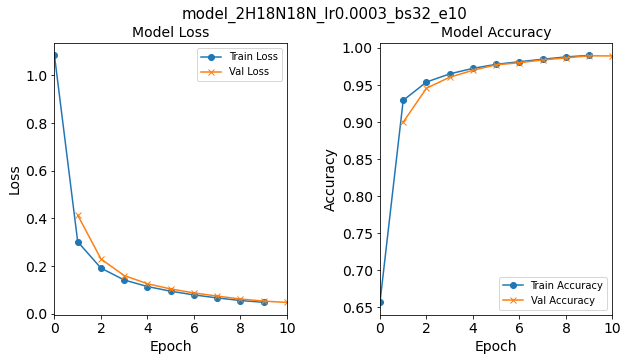

In [124]:
saveOutputs_HL(2, model_2H18N18N_history, model_2H18N18N)

#### Create the NN_Model_3H function that will build and compile a model with 3 hidden layers

In [125]:
def NN_Model_3H(hidden_neurons_1,hidden_neurons_2, hidden_neurons_3, learning_rate):
    """Definition of deep learning model with three dense hidden layers"""
    random_normal_init = tf.random_normal_initializer(mean=0.0, stddev=0.05)
    model = Sequential([
        # More hidden layers can be added here
        Dense(hidden_neurons_1, activation='relu', input_shape=(19,),
              kernel_initializer=random_normal_init), # Hidden Layer
        Dense(hidden_neurons_2, activation='relu',
              kernel_initializer=random_normal_init), # Hidden Layer
        Dense(hidden_neurons_3, activation='relu',
              kernel_initializer=random_normal_init), # Hidden Layer
        Dense(18, activation='softmax',
              kernel_initializer=random_normal_init)  # Output Layer
    ])
    adam_opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam_opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [126]:
#RUNIT
# Reproducibility hacks!

np.random.seed(968172)
tf.random.set_seed(83018241)

In [127]:
# the model with 18 neurons in each of the 3 hidden layers 
model_3H18N18N18N = NN_Model_3H(18,18,18,0.0003)
model_3H18N18N18N_history = model_3H18N18N18N.fit(train_features,
                                      train_L_onehot,
                                      epochs=10, batch_size=32,
                                      validation_data=(val_features, val_L_onehot),
                                      verbose=2)

Epoch 1/10
6827/6827 - 7s - loss: 1.1240 - accuracy: 0.6477 - val_loss: 0.5027 - val_accuracy: 0.8692
Epoch 2/10
6827/6827 - 7s - loss: 0.3834 - accuracy: 0.9127 - val_loss: 0.3083 - val_accuracy: 0.9344
Epoch 3/10
6827/6827 - 7s - loss: 0.2580 - accuracy: 0.9461 - val_loss: 0.2213 - val_accuracy: 0.9559
Epoch 4/10
6827/6827 - 7s - loss: 0.1900 - accuracy: 0.9584 - val_loss: 0.1637 - val_accuracy: 0.9624
Epoch 5/10
6827/6827 - 7s - loss: 0.1425 - accuracy: 0.9639 - val_loss: 0.1233 - val_accuracy: 0.9668
Epoch 6/10
6827/6827 - 7s - loss: 0.1106 - accuracy: 0.9724 - val_loss: 0.0990 - val_accuracy: 0.9750
Epoch 7/10
6827/6827 - 7s - loss: 0.0906 - accuracy: 0.9789 - val_loss: 0.0814 - val_accuracy: 0.9817
Epoch 8/10
6827/6827 - 7s - loss: 0.0775 - accuracy: 0.9823 - val_loss: 0.0737 - val_accuracy: 0.9838
Epoch 9/10
6827/6827 - 7s - loss: 0.0688 - accuracy: 0.9842 - val_loss: 0.0674 - val_accuracy: 0.9829
Epoch 10/10
6827/6827 - 7s - loss: 0.0622 - accuracy: 0.9857 - val_loss: 0.0594 - 

In [129]:
#AdvMetadataVersion
# metadata for the model - (Expt_ID, Job_ID, hidden_neurons, learning_rate, batch_size, epoch)
model_3H18N18N18N_data = ('3H18N18N18N-layers', 19, '[18, 18, 18]', 0.0003, 32, 10) 


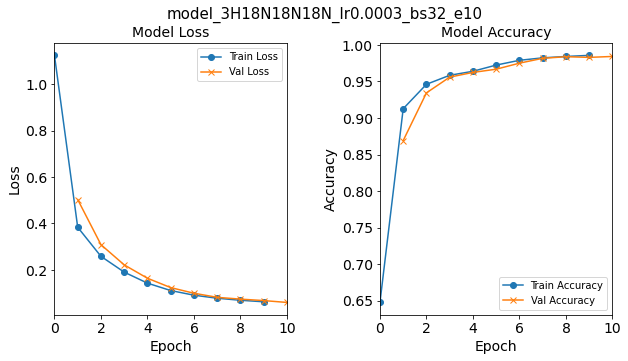

In [130]:
saveOutputs_HL(3, model_3H18N18N18N_history, model_3H18N18N18N)

#### The NN_1H model (the model with 1 hidden layer)
##### For simplicity sake, we will just save the output from the baseline model defined above

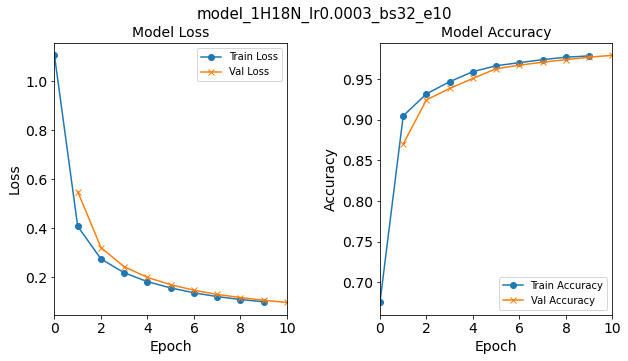

In [131]:
# Save the 1H18N model
saveOutputs_HL(1, model_1H_history, model_1H)

#### Post Processing for Experiment Type 4: Number of Hidden Layers

##### Visual inspection of graphs:

All of them follow the usual trends.

#### Post Processing (Compiling the CSV) for Experiment Type 4: Multiple Hidden Layers

This follows the same format as the hidden neurons with different variable names.
See above for more information. However, this requires a helper function located in the `sherlock_ML_toolbox.py` file called `model_layer_code_XH()`. Test it below.

In [144]:
# Test out model_layer_code_XH(), which provides follows the naming convention.
model_layer_code_XH([32,18])

'2H32N18N'

In [64]:
# outer directory
dirPathHL = dir0_HL

# The hidden layers for each experiment/model.
# The number of hidden neurons in each layer input as a list.
# Each number in the list is the number of neurons in that layer.
listHL = [[18], [18, 18], [18, 18, 18]]

# Number of epochs - 1
lastEpochNum = 9 

# Initalize. This will hold the list of dictionaries of last epoch metrics
# (loss, val_loss, accuracy, val_accuracy)
all_lastEpochMetrics_HL = []

# Fill in the rows for the DataFrame
for HL in listHL:
    # Read the history CSV file and get the last row's data, which corresponds to the last epoch data.
    result_csv = fn_out_history_XH(dirPathHL, HL, 0.0003, 32, lastEpochNum+1)
    print("Reading:", result_csv)
    epochMetrics = pd.read_csv(result_csv)
    # Fetch the loss, accuracy, val_loss, and val_accuracy from the last epoch
    # (should be the last row in the CSV file unless there's something wrong
    # during the traning)
    lastEpochMetrics = epochMetrics.iloc[lastEpochNum, :].to_dict()
    # Attach the "layers" value
    lastEpochMetrics["neurons"] = HL
    all_lastEpochMetrics_HL.append(lastEpochMetrics)

Reading: scan-layers/model_1H18N_lr0.0003_bs32_e10/model_history.csv
Reading: scan-layers/model_2H18N18N_lr0.0003_bs32_e10/model_history.csv
Reading: scan-layers/model_3H18N18N18N_lr0.0003_bs32_e10/model_history.csv


Now construct the `df_HL` dataframe:

In [65]:
df_HL = pd.DataFrame(all_lastEpochMetrics_HL, 
                     columns=["neurons", "loss", "accuracy", "val_loss", "val_accuracy"])

In [66]:
print(df_HL)

        neurons      loss  accuracy  val_loss  val_accuracy
0          [18]  0.099545  0.978559  0.097021      0.979219
1      [18, 18]  0.047560  0.989797  0.047009      0.988996
2  [18, 18, 18]  0.062198  0.985700  0.059368      0.984199


##### Save the post-processing results for the hidden layer experiments

In [67]:
df_HL.to_csv("post_processing_layers.csv", index=False)

In [68]:
# #AdvMetadataVersion
# # Baseline model with be the same as before, but with different meta-data
# # model_1H18N_data = ('1H18N-layers', 20, '[18]', 0.0003, 32, 10) 
# model_1H18N_history = model_1H_history 

# histories = [model_2H18N18N_history, model_3H18N18N18N_history, model_1H18N_history]
# metaData = [model_2H18N18N_data, model_3H18N18N18N_data, model_1H18N_data]

# df = createDataFrame(metaData, histories)

# print(df) 
# df.to_csv("post_processing_layers.csv", index=False)

## Additional Tuning Opportunities

There are other hyperparameters that can be adjusted:

  * Change the optimizer (try optimizers other than `Adam`)
  * Activation function  (this is actually a part of the network's architecture)

We encourage you to explore the effects of changing these in your network.

## Closing Remarks

This process of experimentation with different parameters for the neural network can get repetitive and cause this notebook to become very long.
Instead, it would be more beneficial to run experiments like this in a scripting environment.
To do this, we need to identify the relevant code elements for our script.
In a general sense, this is what we should pick out:

* Useful Python libraries & user-defined functions
* Proper sequence of commands that were run throughout this notebook (i.e. one-hot encoding must be done before training the models)
* Code cells that require repetition

In brief, once the initial experiments are done and we have established a working pipeline for machine learning, we need to change the way we work.
Real machine learning work requires many repetitive experiments, each of which may take a long time to complete.
Instead of running many experiments in Jupyter notebooks, where each will require us to wait for a while to finish, we need to be able to carry out many experiments in parallel so that we can obtain our results in a timely manner.
This is key reason why we should make a script for these experiments and submit the script to run them in batch (non-interactive model).
HPC is well suited for this type of workflow--in fact it is most efficient when used in this way.
Here are the key components of the "batch" way of working:

* A job scheduler (such as SLURM job scheduler on HPC) to manage our jobs and run them on the appropriate resources;
* The machine learning script written in Python, which will read inputs from files and write outputs to files and/or standard output;
* The job script to launch the machine learning script in the non-interactive environment (e.g. HPC compute node);
* A way to systematically repeat the experiments with some variations. This can be done by adding some command-line arguments for the (hyper)parameters that will be varied for each experiment.